In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.axes_grid1 import make_axes_locatable
from scipy.spatial import ConvexHull, convex_hull_plot_2d 
from source_draft import preprocess as prep

from scipy.stats import entropy
from Bio import SeqIO

In [2]:
plt.rcParams.update({'font.family': 'Arial'})
plt.rcParams.update({'font.size': 9})

In [3]:
# Natural sequences
merge_ds = pd.read_excel('data/20210908_natural_with_taxonomy.xls').iloc[:,1:]
SH3 = merge_ds['Sequences']
mmd_nat_coord = np.array(merge_ds[['MMD_z0','MMD_z1','MMD_z2']])

RE_nat = merge_ds['norm_RE']
good_nat = [i for i in range(len(RE_nat)) if RE_nat[i]>.5 and RE_nat[i]<10]
nogood_nat = [i for i in range(len(RE_nat)) if RE_nat[i]<.5 and RE_nat[i]>-10]

In [4]:
# designed sequences
design_sheet = pd.read_excel('data/20210826_design_sheet.xls')
designed_seq = design_sheet['seq'][:11608].tolist()
designed_seq = [i[:16]+i[18:44]+i[45:] for i in designed_seq]
res = design_sheet['RE_norm']

VAE_global,VAE_local,mmd_global,mmd_local,bm = \
np.arange(1,3985),np.arange(3985,4881),np.arange(8621,10621),np.arange(10621,11608),np.arange(4881,8621)

design_mmd = np.array(design_sheet.loc[:11607,['MMD_z0','MMD_z1','MMD_z2']]) # designed mmd coordinates
good_design = np.array([i for i in range(11607) if res[i]>=.5])
nogood_design = np.array([i for i in range(11607) if res[i]<.5])

mmd_all = np.hstack([mmd_global,mmd_local])
good_des_mmd = np.array([i for i in mmd_all if i in good_design])
no_good_des_mmd = np.array([i for i in mmd_all if i not in good_design])

In [5]:
good_nat_mmd_coor = mmd_nat_coord[good_nat,:]
nogood_nat_mmd_coor = mmd_nat_coord[nogood_nat,:]

good_des_mmd_coor= design_mmd[good_des_mmd]
nogood_des_mmd_coor = design_mmd[no_good_des_mmd]

## Taxonomy figures

In [6]:
ortho_list = merge_ds['orthologous_group'].tolist()
u_o = np.unique(ortho_list)[:-1]
cdict=np.arange(len(u_o))

z_x, z_y = [0,0,1], [1,2,2]

In [7]:
phylogeny = ['Saccharomycotina', 'Pezizomycotina', 'Basidiomycota']

merge_ds['PhyGroup'] = np.nan
for j in range(len(phylogeny)):
    filter_1 = merge_ds['Phylogeny'].str.contains(phylogeny[j])
    merge_ds.loc[filter_1,'PhyGroup'] = phylogeny[j]

nodik = 'non-Dikarya fungi'
phylogeny.append(nodik)
filter_2 = ~merge_ds['Phylogeny'].str.contains('Dikarya')
filter_3 = merge_ds['Phylogeny'].str.contains('Fungi')
merge_ds.loc[filter_2 & filter_3,'PhyGroup'] = nodik

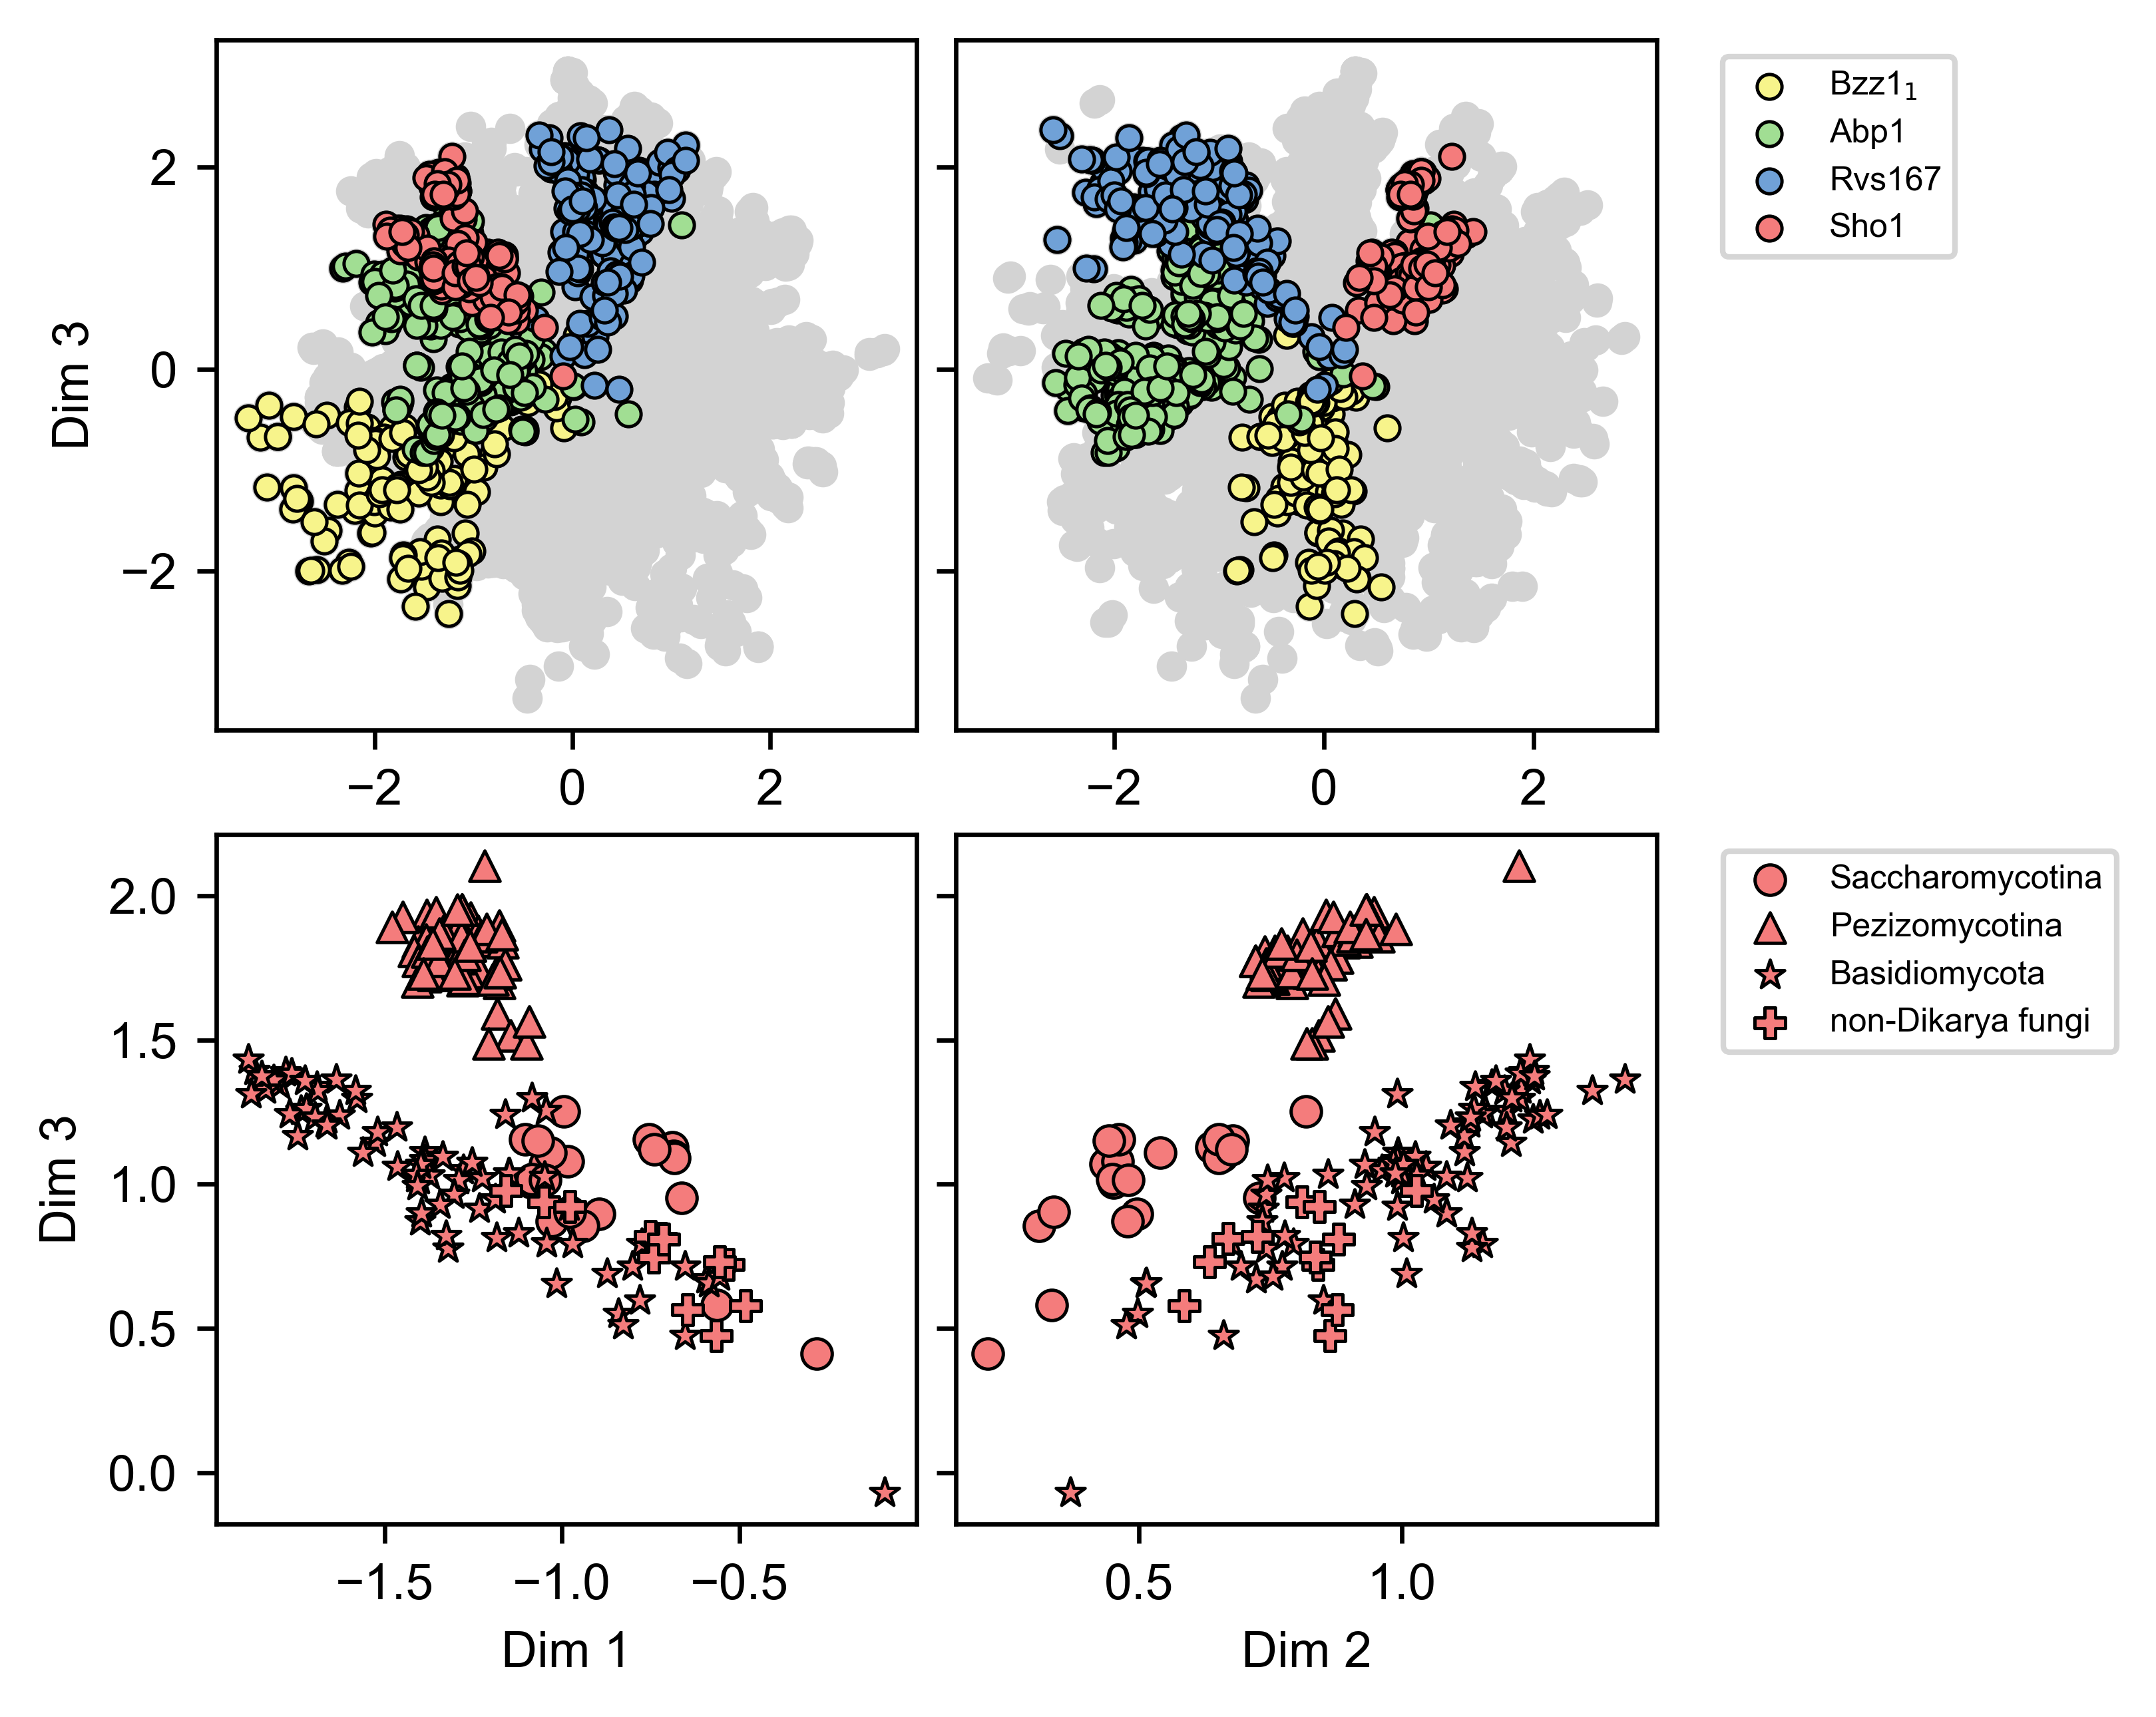

In [8]:
# Classify orthology and phylogeny for four typical paralogs including Sho1

fig, ax = plt.subplots(2,2,figsize=(5.4,4.2),
                       gridspec_kw=dict(height_ratios=[2,2],width_ratios=[2,2]),dpi=600)
for j in range(2):
    ax[0,j].scatter(mmd_nat_coord[:,j], mmd_nat_coord[:,2], c = 'lightgray', s = 20)
    ax[j,0].set_ylabel('Dim 3')
    for g in range(4):
        ix = np.where(np.array(ortho_list) == ['KOG3565_1','KOG3655','KOG3771','NOG09120'][g])[0]
        ax[0,j].scatter(mmd_nat_coord[ix,j], mmd_nat_coord[ix,2],
                        c = ['#f7f48b','#a1de93','#70a1d7','#f47c7c'][g], 
                        label = [r'Bzz1$_{1}$','Abp1','Rvs167','Sho1'][g], edgecolor = 'k', linewidth=0.6,s = 20)
        
        ix = np.where((merge_ds['PhyGroup'] == phylogeny[g]) & (merge_ds['orthologous_group'] == 'NOG09120'))[0]
        ax[1,j].scatter(mmd_nat_coord[ix,j], mmd_nat_coord[ix,2], 
                        marker = ['o','^','*','P'][g], c = '#f47c7c',
                        label = phylogeny[g], edgecolor = 'k', linewidth=0.6,s = 30)
        
ax[0,1].legend(loc='upper right', bbox_to_anchor=(1.45, 1),fontsize=6)
ax[1,1].legend(loc='upper right', bbox_to_anchor=(1.68, 1),fontsize=6)
ax[1,0].set_xlabel('Dim 1')
ax[1,1].set_xlabel('Dim 2')
plt.setp(ax[0,1].get_yticklabels(), visible=False)
plt.setp(ax[1,1].get_yticklabels(), visible=False)
plt.tight_layout(pad=.4)
#plt.savefig('../VAE_design_paper/Fig1/latent_3.svg')
plt.show()

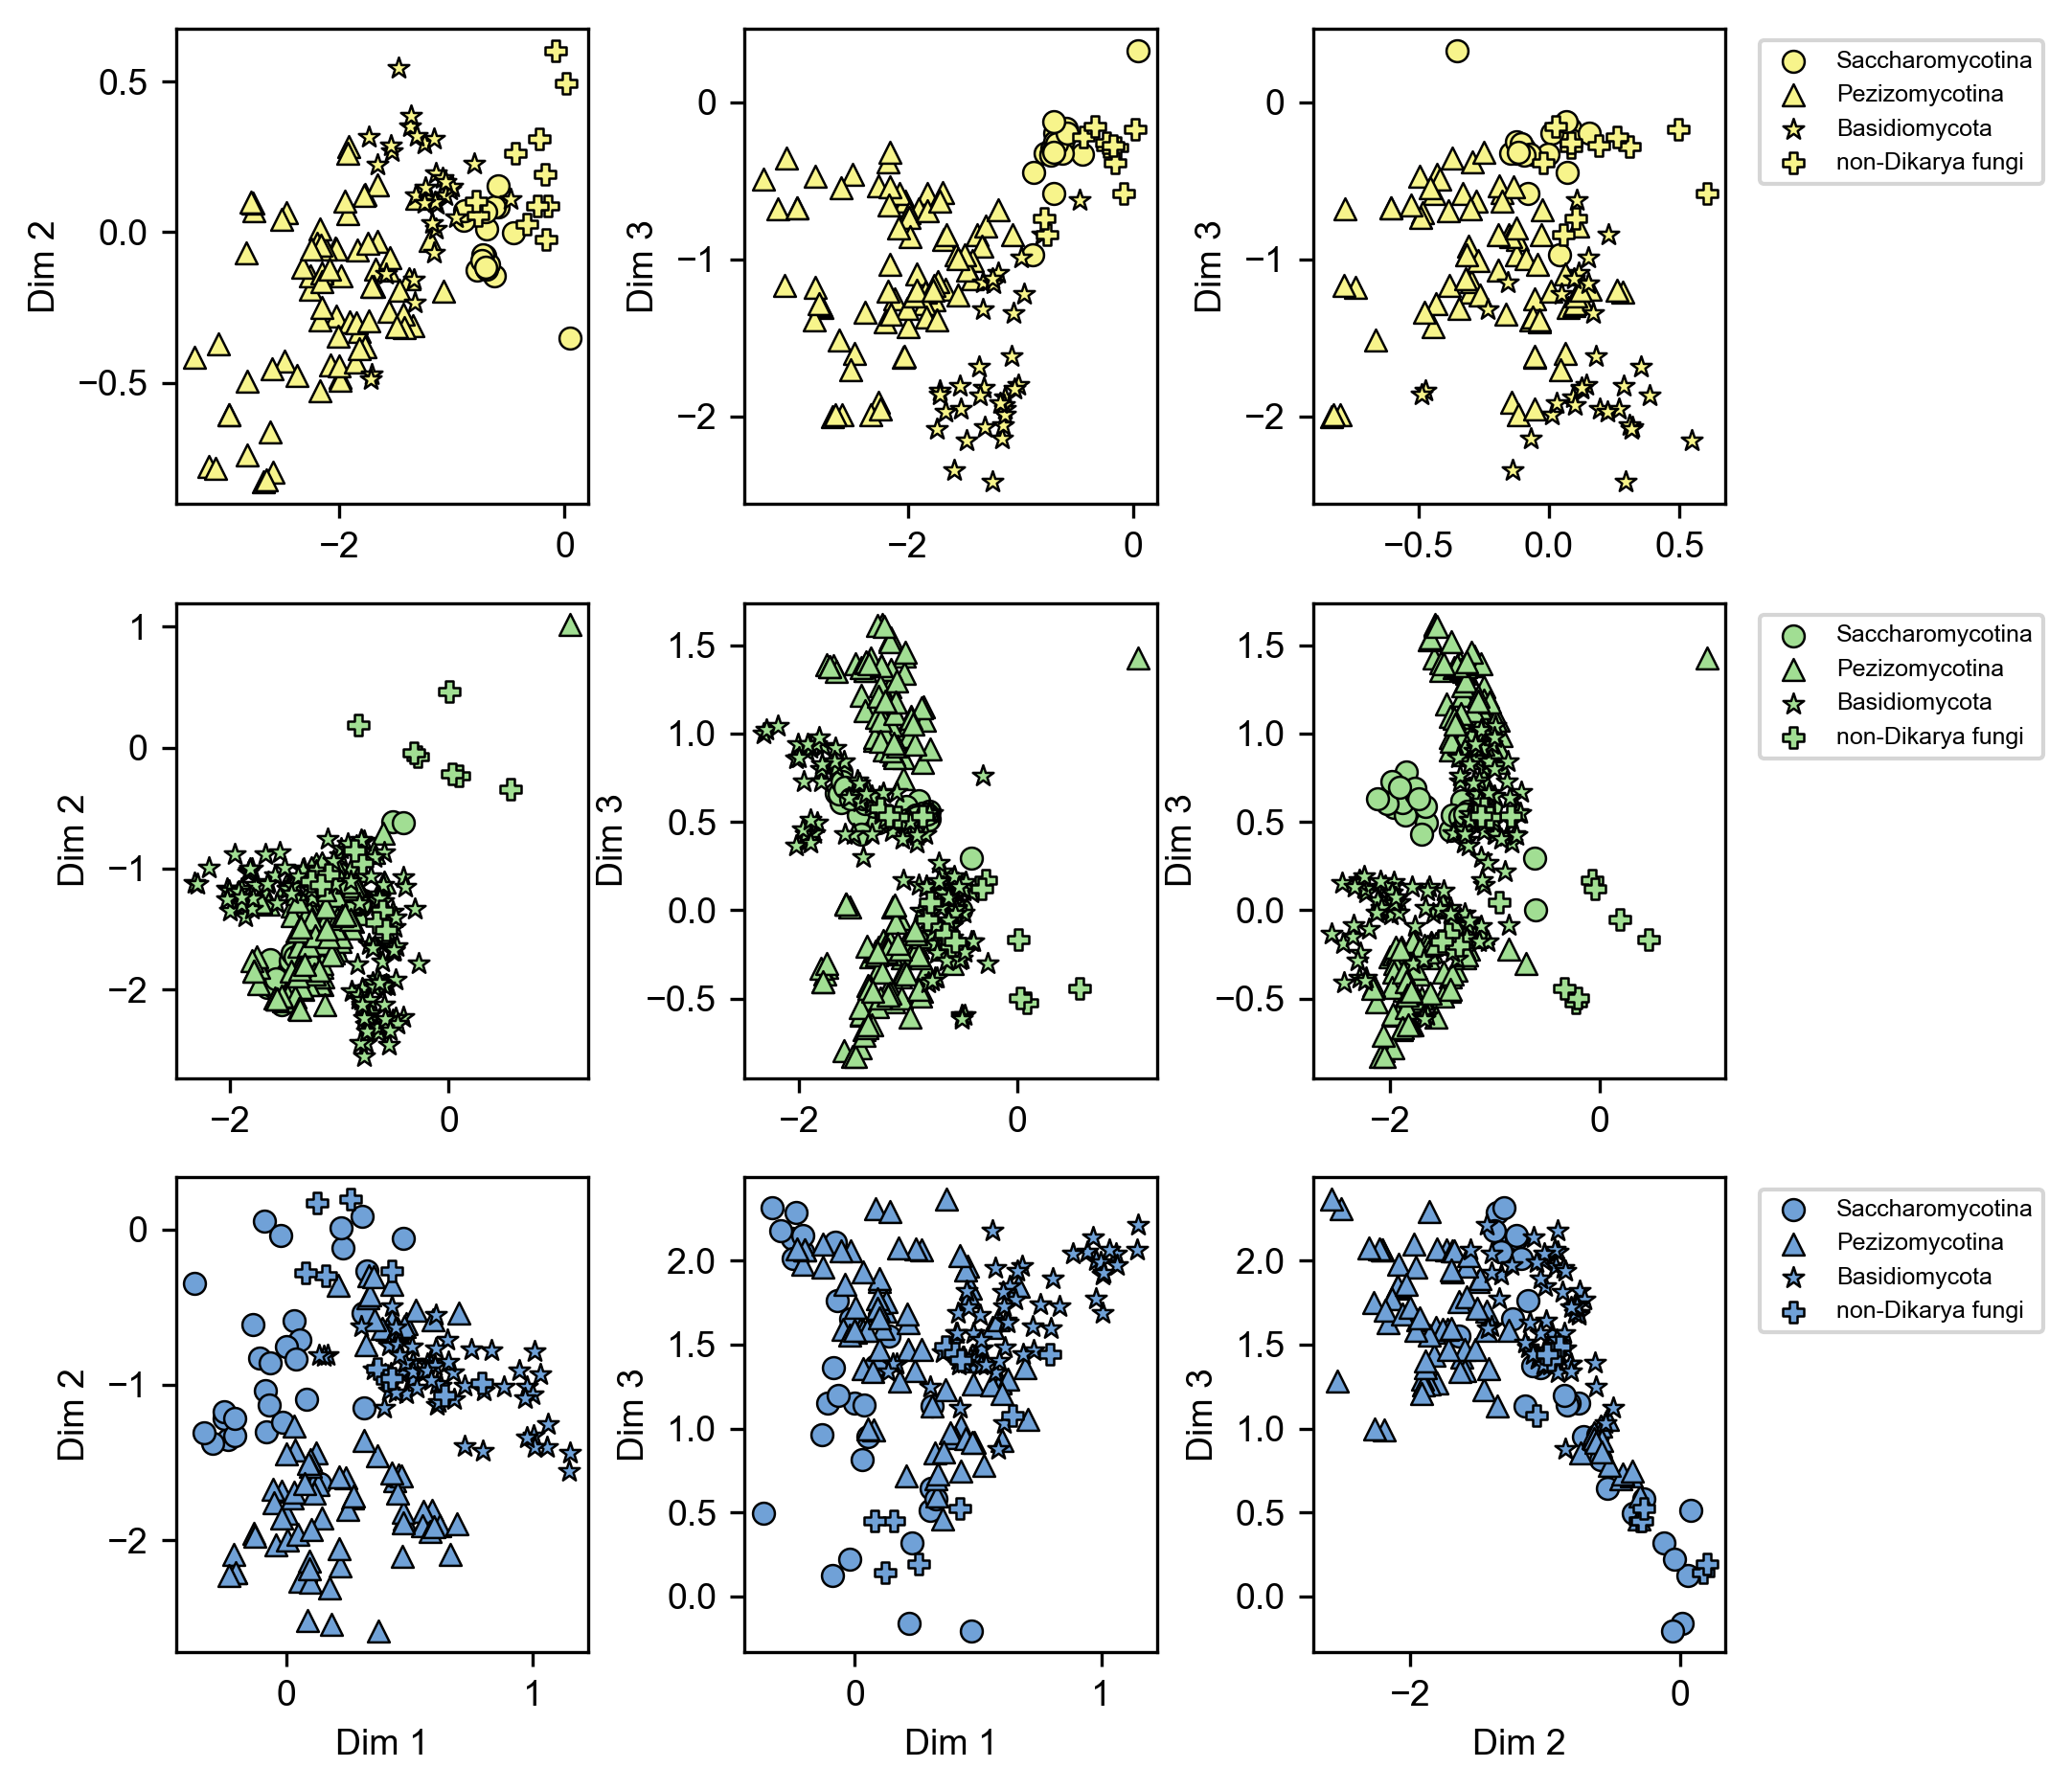

In [9]:
# Phylogeny structure for the four groups

fig, ax = plt.subplots(3,3,figsize=(7.5,6.3),dpi=300)
for j in range(3):
    ax[2,j].set_xlabel('Dim '+ str(z_x[j]+1))
    for i in range(3):
        ax[j,i].set_ylabel('Dim ' + str(z_y[i]+1))
        for g in range(4):
            ix = np.where((merge_ds['PhyGroup'] == phylogeny[g]) & (merge_ds['orthologous_group'] == 
                                                             ['KOG3565_1','KOG3655','KOG3771'][j]))[0]
            ax[j,i].scatter(mmd_nat_coord[ix, z_x[i]], mmd_nat_coord[ix, z_y[i]], 
                            marker = ['o','^','*','P'][g], c = ['#f7f48b','#a1de93','#70a1d7'][j],
                            label = phylogeny[g], edgecolor = 'k',linewidth=0.6,s = 30)        
    ax[j,2].legend(loc='upper right', bbox_to_anchor=(1.8, 1),fontsize=6)
plt.tight_layout()
plt.show()

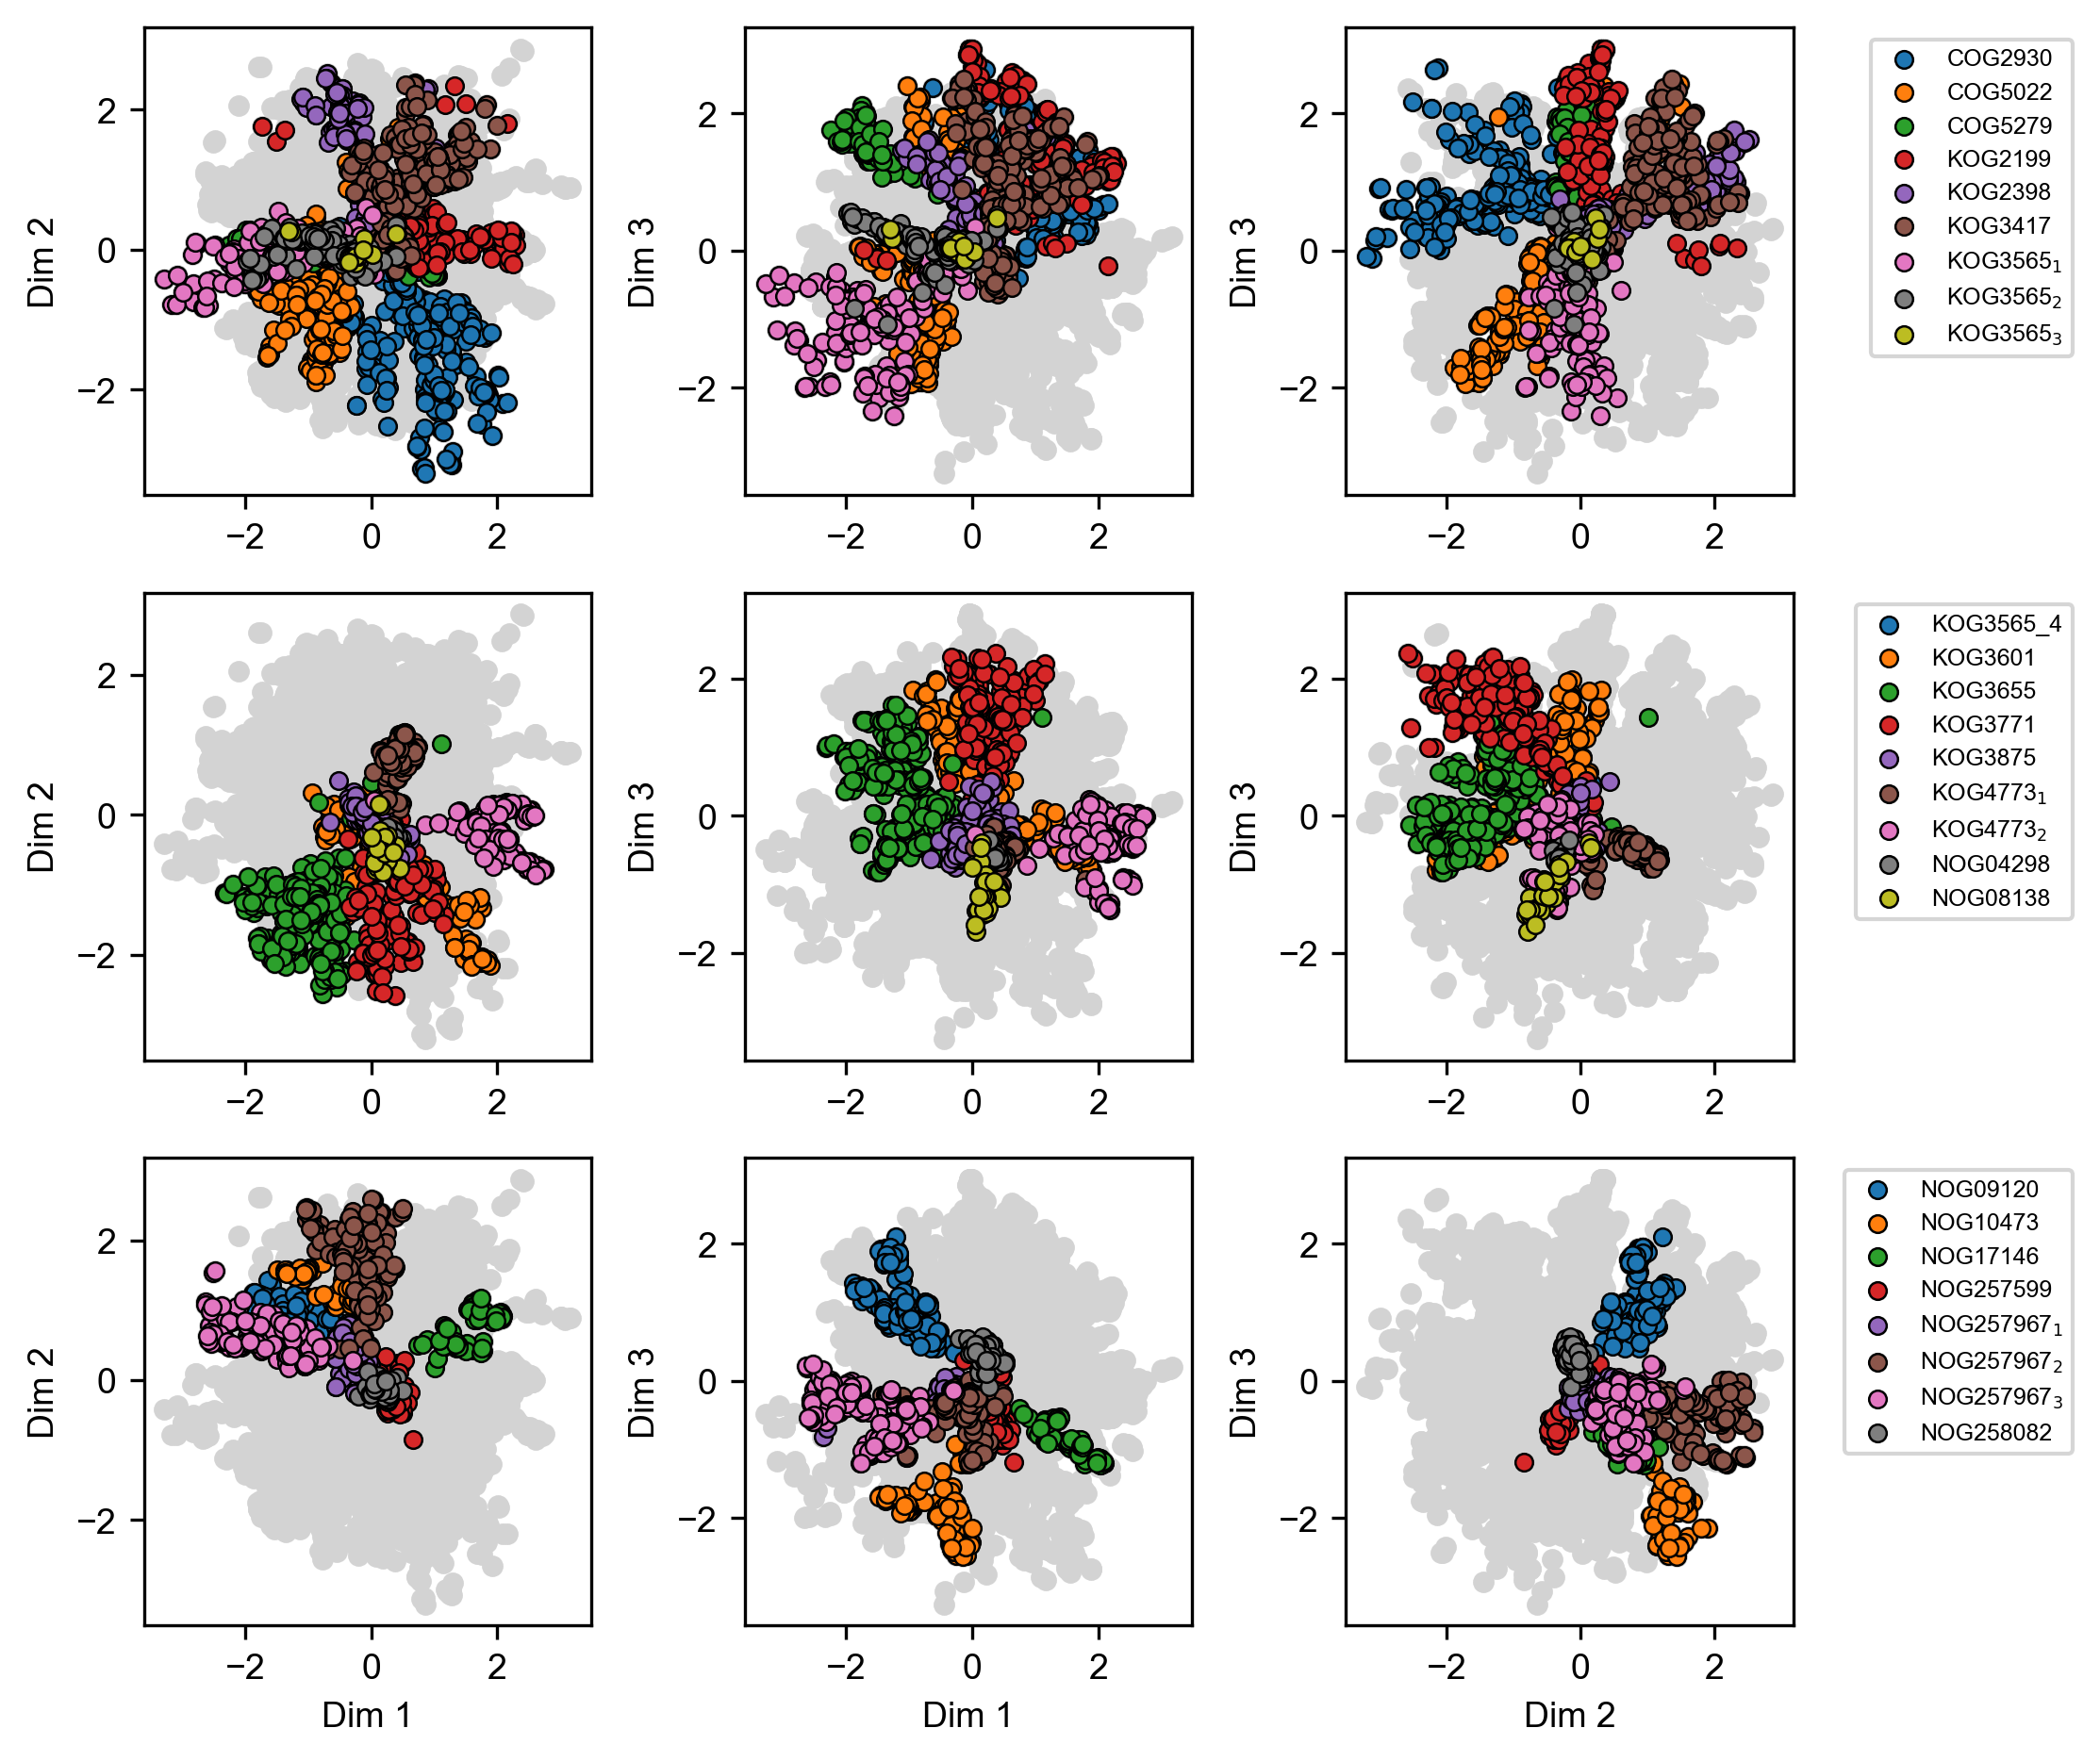

In [10]:
# Orthology structure for all 24 paralogs

u_o_update = u_o
for i in range(1,4):
    u_o_update = [j.replace('_%d'%i,'$_%d$'%i) for j in u_o_update]

fig, ax = plt.subplots(3,3,figsize=(7.5,6.3),dpi=300)
c_list = [np.arange(9),np.arange(9,18),np.arange(18,26)]

for i in range(3):
    ax[2,i].set_xlabel('Dim '+ str(z_x[i]+1))
    for j in range(3):
        ax[i,j].set_ylabel('Dim '+ str(z_y[j]+1))
        ax[i,j].scatter(mmd_nat_coord[:,z_x[j]], mmd_nat_coord[:,z_y[j]], c = 'lightgray', s = 20)
        for g in cdict[9*i:9*(i+1)]:
            ix = np.where(np.array(ortho_list) == u_o[g])[0]
            ax[i,j].scatter(mmd_nat_coord[ix,z_x[j]], mmd_nat_coord[ix,z_y[j]], 
                            label = u_o_update[g], edgecolor = 'k', s = 20, linewidth=0.6)
    ax[i,2].legend(loc='upper right', bbox_to_anchor=(1.65, 1), fontsize=6)

    plt.tight_layout()
plt.show()

In [11]:
phylogeny = ['Saccharomycotina', 'Pezizomycotina', 'Basidiomycota']
phy_list_mmd = []
for j in range(len(phylogeny)):
    filter_4 = merge_ds['Phylogeny'].str.contains(phylogeny[j])
    phy_list_mmd.append(np.array(mmd_nat_coord[filter_4]))
phylogeny.append('non-Dikarya fungi')
phy_list_mmd.append(np.array(mmd_nat_coord[filter_2 & filter_3]))

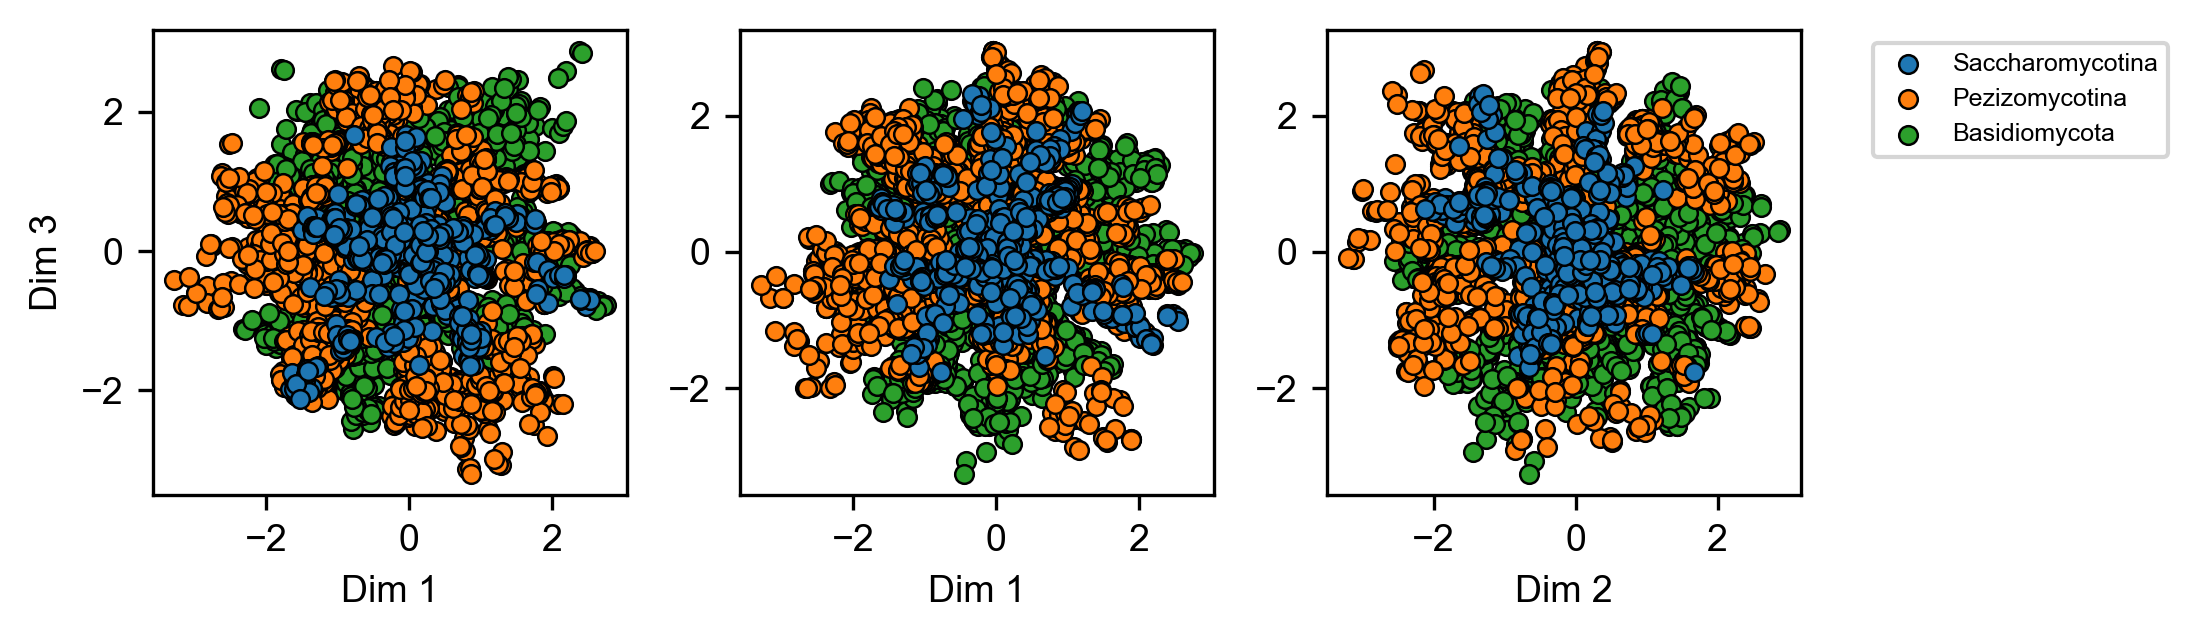

In [12]:
fig, ax = plt.subplots(1,3,figsize=(7.5,2.2),dpi=300)
for i in range(3):
    ax[i].set_xlabel('Dim '+ str(z_x[i]+1))
    for j in [0,1,2]:
        ax[i].scatter(phy_list_mmd[j][:,z_x[i]], phy_list_mmd[j][:,z_y[i]], 
                      label = phylogeny[j], edgecolor = 'k',s = 20 ,linewidth=0.6, zorder = 3-j)
ax[2].legend(loc='upper right', bbox_to_anchor=(1.8, 1),fontsize=6)
ax[0].set_ylabel('Dim '+ str(z_y[i]+1))
plt.tight_layout()
plt.show()

## Plot Figure 4A (with phylogeny of natural Sho1-SH3 sequences)
* **Red**: natural sequences and phylogeny (Markers are the same as Figure 1D)
* **Yellow**: Functional infoVAEdesigned sequences. (They fill gaps between natural sequences.)
* **Blue**: Unfunctional infoVAE designed sequences.

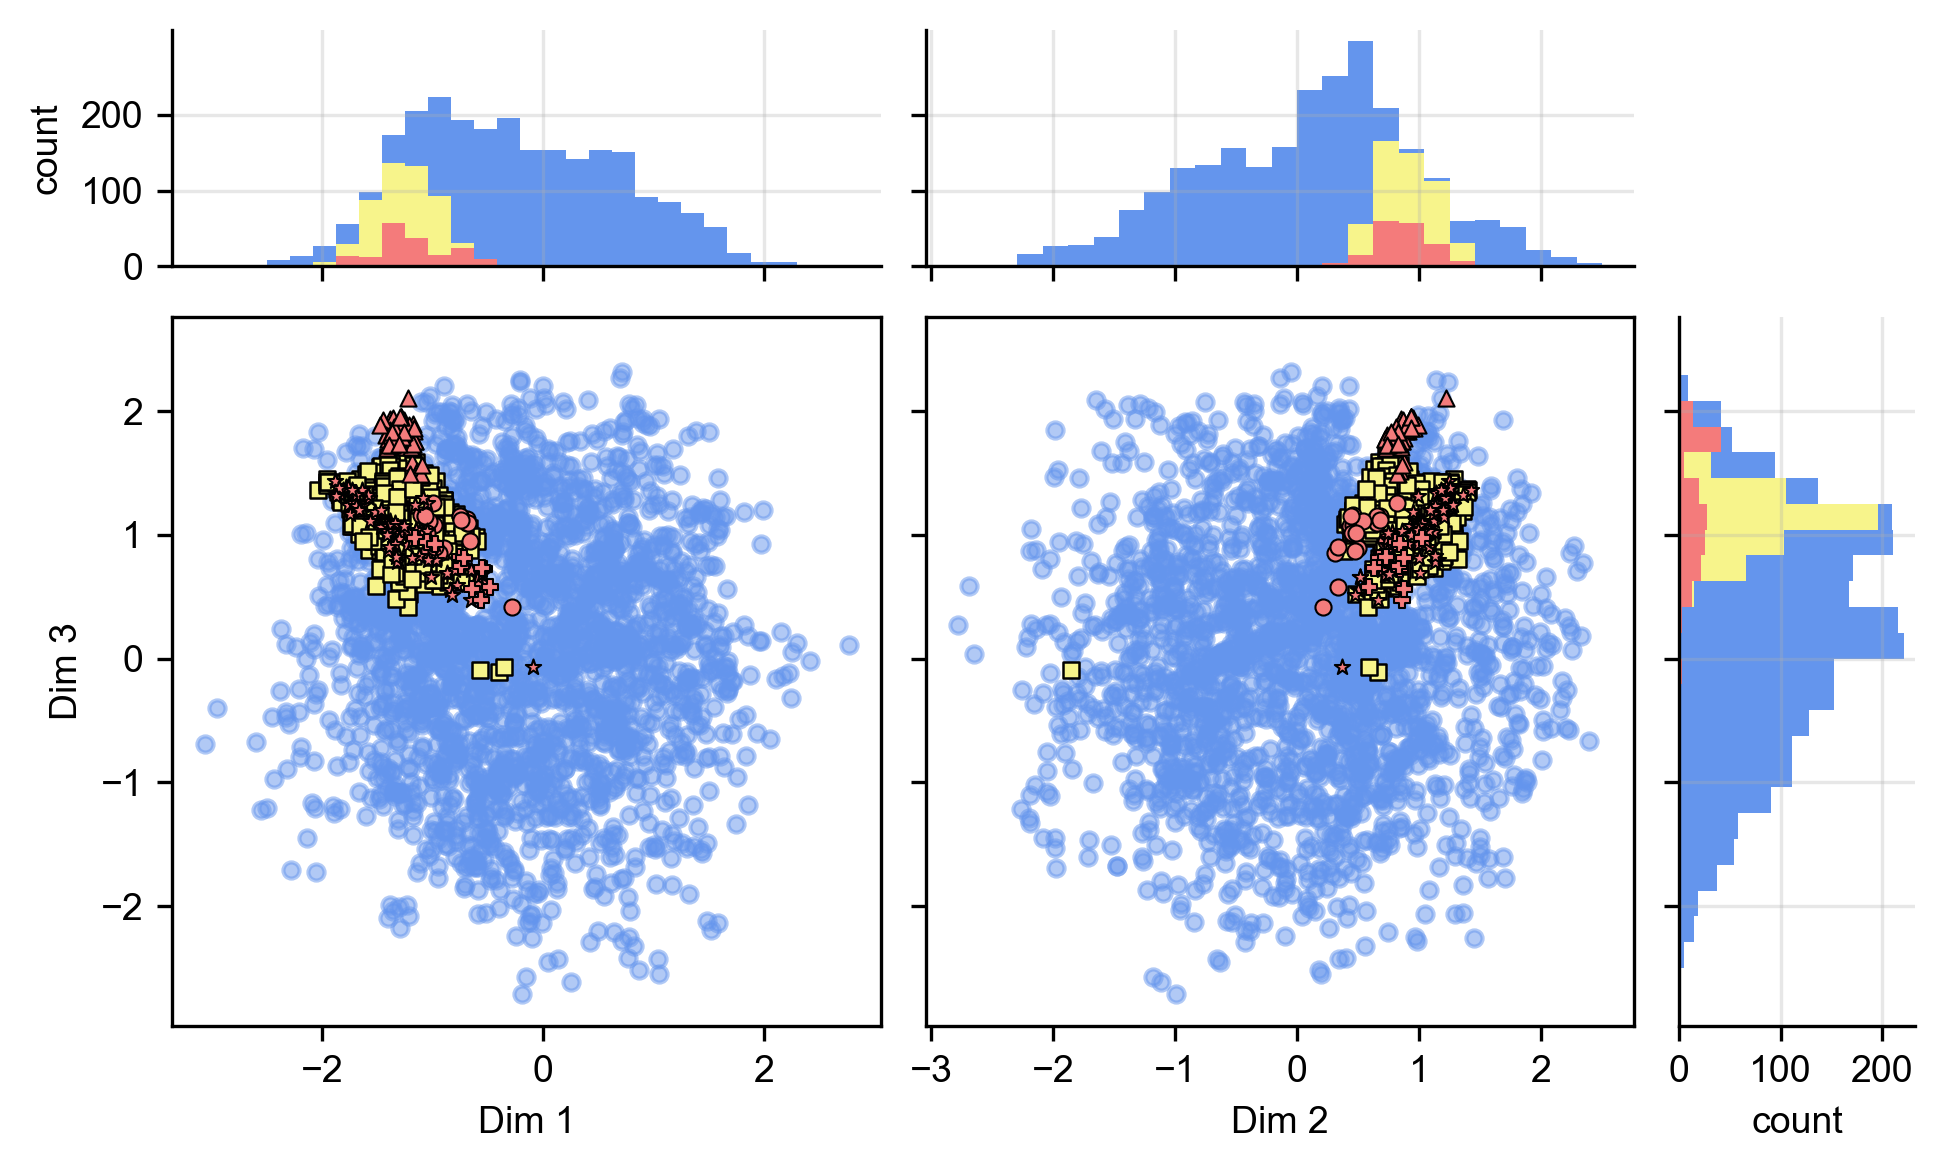

In [13]:
plt.rcParams.update({'font.size': 9})
dsize = 1
size =15
lw=.5
bins = np.linspace(-2.5,2.5,25)

fig, axs = plt.subplots(2,3,figsize = [6.5,3.9], sharex="col", sharey="row",
                         gridspec_kw=dict(height_ratios=[1,3],width_ratios=[3,3,1]),dpi=300)
axs[0, 2].set_visible(False)

for i in range(2):
    axs[1,i].scatter(design_mmd[no_good_des_mmd,i], design_mmd[no_good_des_mmd,2],s=size, c = 'cornflowerblue',alpha=.5)
    axs[1,i].scatter(design_mmd[good_des_mmd,i], design_mmd[good_des_mmd,2],s=size, c = '#F7F48B', 
                     linewidth=0.6, edgecolor='k',marker='s')
    
    for g in range(4):
        ix = np.where((merge_ds['PhyGroup'] == phylogeny[g]) & (merge_ds['orthologous_group'] == 'NOG09120'))[0]
        axs[1,i].scatter(mmd_nat_coord[ix,i], mmd_nat_coord[ix,2], 
                    marker = ['o','^','*','P'][g], c = '#f47c7c', edgecolor = 'k', linewidth=lw,s = size)
    
    axs[0,i].hist(design_mmd[no_good_des_mmd,i],bins, color = 'cornflowerblue',)
    axs[0,i].hist(design_mmd[good_des_mmd,i],bins, color = '#F7F48B')
    axs[0,i].hist(mmd_nat_coord[good_nat,i],bins, color = '#f47b7b')
    axs[0,i].grid(alpha=.3)
    axs[0,i].spines['right'].set_visible(False)
    axs[0,i].spines['top'].set_visible(False)
    axs[0,i].set_yticks([0,100,200])

axs[1,2].hist(design_mmd[no_good_des_mmd,2],bins, orientation='horizontal', color = 'cornflowerblue')
axs[1,2].hist(design_mmd[good_des_mmd,2],bins, orientation='horizontal', color = '#F7F48B')
axs[1,2].hist(mmd_nat_coord[good_nat,2],bins, orientation='horizontal', color = '#f47b7b')
axs[1,2].spines['right'].set_visible(False)
axs[1,2].spines['top'].set_visible(False)
axs[1,2].set_xticks([0,100,200])
axs[1,2].grid(alpha=.3)
    
axs[1,0].set_xlabel('Dim 1')
axs[1,0].set_ylabel('Dim 3')
axs[1,1].set_xlabel('Dim 2')
axs[0,0].set_ylabel('count')
axs[1,2].set_xlabel('count')

plt.tight_layout(pad=.8)
plt.show()

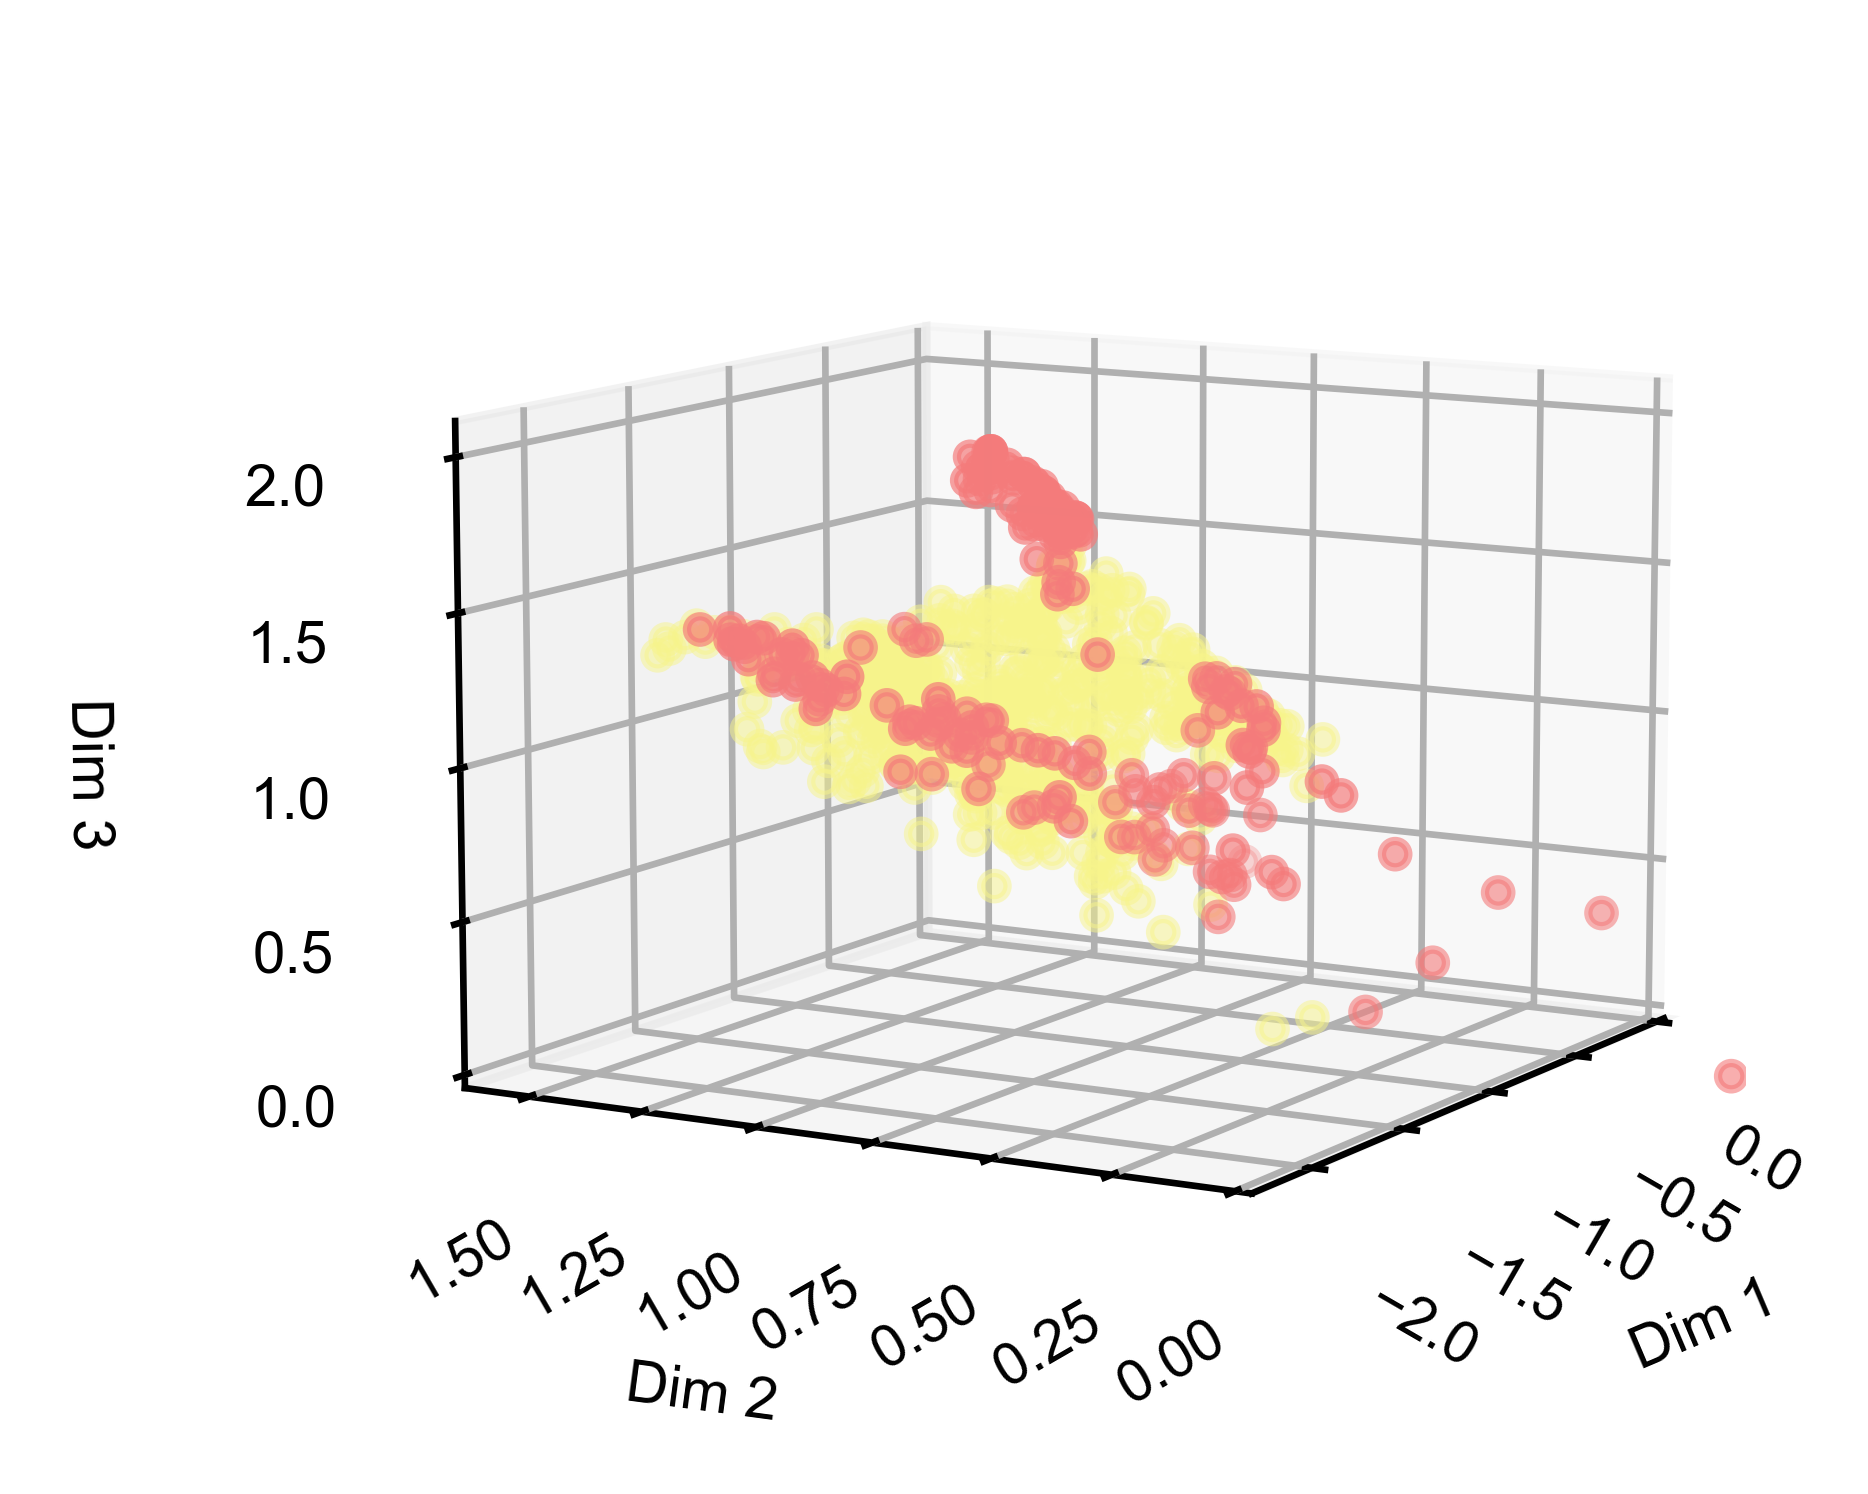

In [14]:
# 3D plot

plt.rcParams.update({'font.size': 7})
s=10
fig = plt.figure(figsize=[2.5,2.5],dpi=600)
ax = fig.add_subplot(111, projection='3d')
ax.scatter(mmd_nat_coord[good_nat[:],0],mmd_nat_coord[good_nat[:],1], 
           mmd_nat_coord[good_nat[:],2], s=s,c = '#f47b7b')
ax.scatter(design_mmd[good_des_mmd,0],design_mmd[good_des_mmd,1],design_mmd[good_des_mmd,2],
           s=s, c = '#F7F48B',alpha=.5)
ax.set_xlabel('Dim 1')
ax.set_ylabel('Dim 2')
ax.set_zlabel('Dim 3')
ax.set_xlim(right=-0.)
ax.set_ylim(bottom=0.)
ax.set_zlim(bottom=0.)
plt.yticks(rotation=30)
plt.xticks(rotation=-30)

ax.view_init(elev=10., azim=210)
plt.tight_layout()
plt.show()

## Define convex hull functions.

In [6]:
def compute_hull(data, hull):
    ix = np.where(data == hull)[0]
    coord = mmd_nat_coord[ix,:]
    return ConvexHull(coord)

def check_latent_in_hull(z_coord, hull, tolerance = 10**-12):
    decision = all((np.dot(equa[:-1], z_coord) + equa[-1] <= tolerance) for equa in hull.equations)
    return decision

def check_hull_list(l, hull):
    return np.array([check_latent_in_hull(i, hull) for i in l])

def freq_mat(heatmap_list):
    frequence = np.zeros([21, 59])
    listseq = np.array([list(i) for i in heatmap_list])
    for num, i in enumerate('-ACDEFGHIKLMNPQRSTVWY'):
        for j in range(59):
            frequence[num,j] = np.count_nonzero(listseq[:,j]==i)/len(heatmap_list)
    return(frequence)

def compute_entropy(seq):
    return entropy(freq_mat(seq),base=2)

## Functional Sho1 hull

In [7]:
ortho_mmd = good_nat_mmd_coor 

ortho_mmd = ortho_mmd[ortho_mmd[:,0] < -.4, :] # remove outliers
ortho_mmd = ortho_mmd[ortho_mmd[:,1] > 0., :]

ortho_hull = ConvexHull(ortho_mmd)

In [8]:
class_nat = check_hull_list(mmd_nat_coord,ortho_hull)

des_mmd_coor = design_mmd[mmd_local]
class_des_mmd = check_hull_list(des_mmd_coor,ortho_hull)

func_class_nat = check_hull_list(good_nat_mmd_coor,ortho_hull)
nofunc_class_nat = check_hull_list(nogood_nat_mmd_coor,ortho_hull)

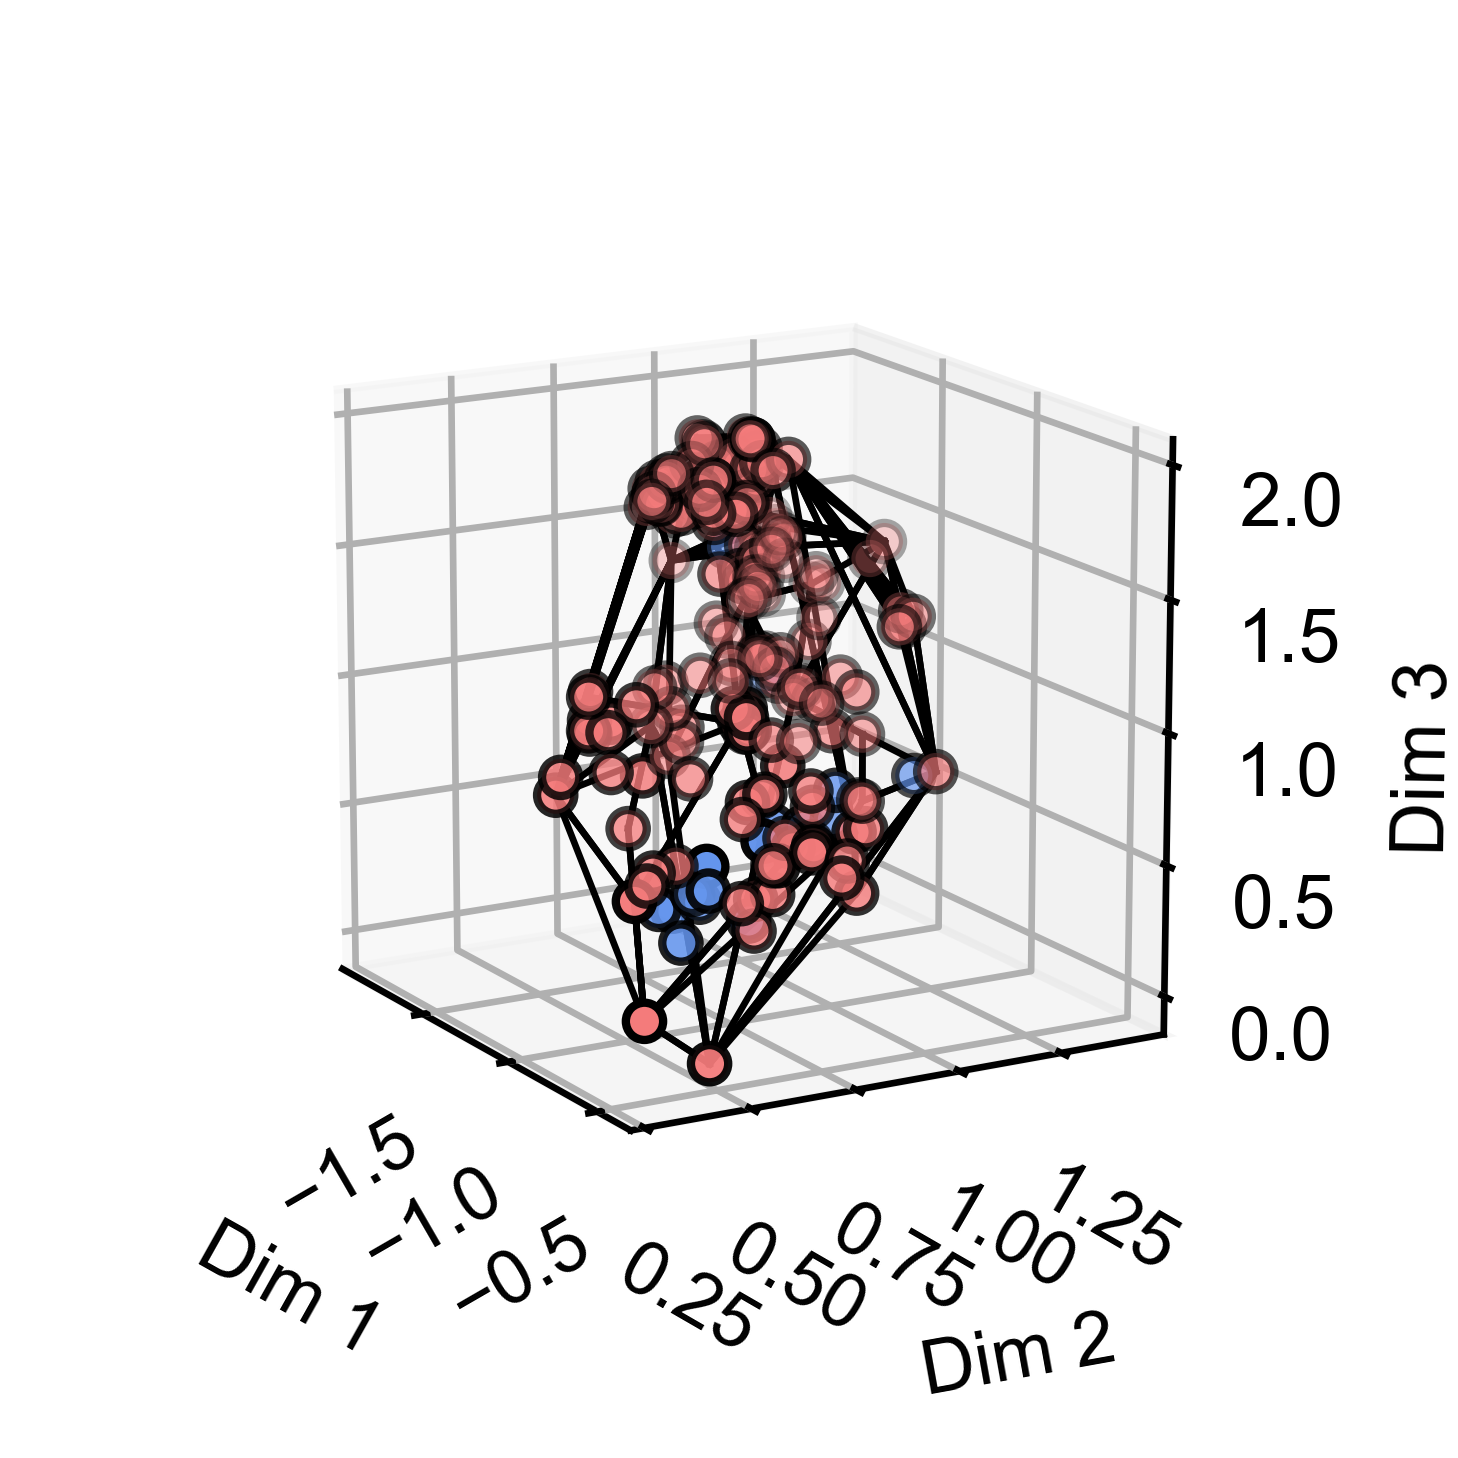

In [9]:
for fig_idx, rot_val in zip([0], [-30]):
    fig = plt.figure(figsize = (2.5,2.5),dpi = 600)

    ax = plt.axes(projection="3d")
    ax.view_init(15, rot_val)

    p = ax.scatter(nogood_nat_mmd_coor[nofunc_class_nat==1,0], nogood_nat_mmd_coor[nofunc_class_nat==1,1], 
                   nogood_nat_mmd_coor[nofunc_class_nat==1,2], c = 'cornflowerblue', edgecolor = 'k', s = 20)
    
    p = ax.scatter(good_nat_mmd_coor[func_class_nat==1,0], good_nat_mmd_coor[func_class_nat==1,1], 
                   good_nat_mmd_coor[func_class_nat==1,2], c='#f47b7b', edgecolor = 'k', s = 20)

    for simplex in ortho_hull.simplices:
        ax.plot(ortho_mmd[simplex, 0], ortho_mmd[simplex, 1],  ortho_mmd[simplex, 2], 'k-',lw=.8)

    ax.set_xlabel('Dim 1', labelpad=9)
    ax.set_ylabel('Dim 2', labelpad=9)
    ax.set_zlabel('Dim 3')
    ax.dist = 12.4
    plt.yticks(rotation=-30)
    plt.xticks([-1.5,-1,-.5],rotation=30)
plt.tight_layout()

In [10]:
fdp = check_hull_list(good_des_mmd_coor,ortho_hull) 
ufdp = check_hull_list(nogood_des_mmd_coor,ortho_hull) 

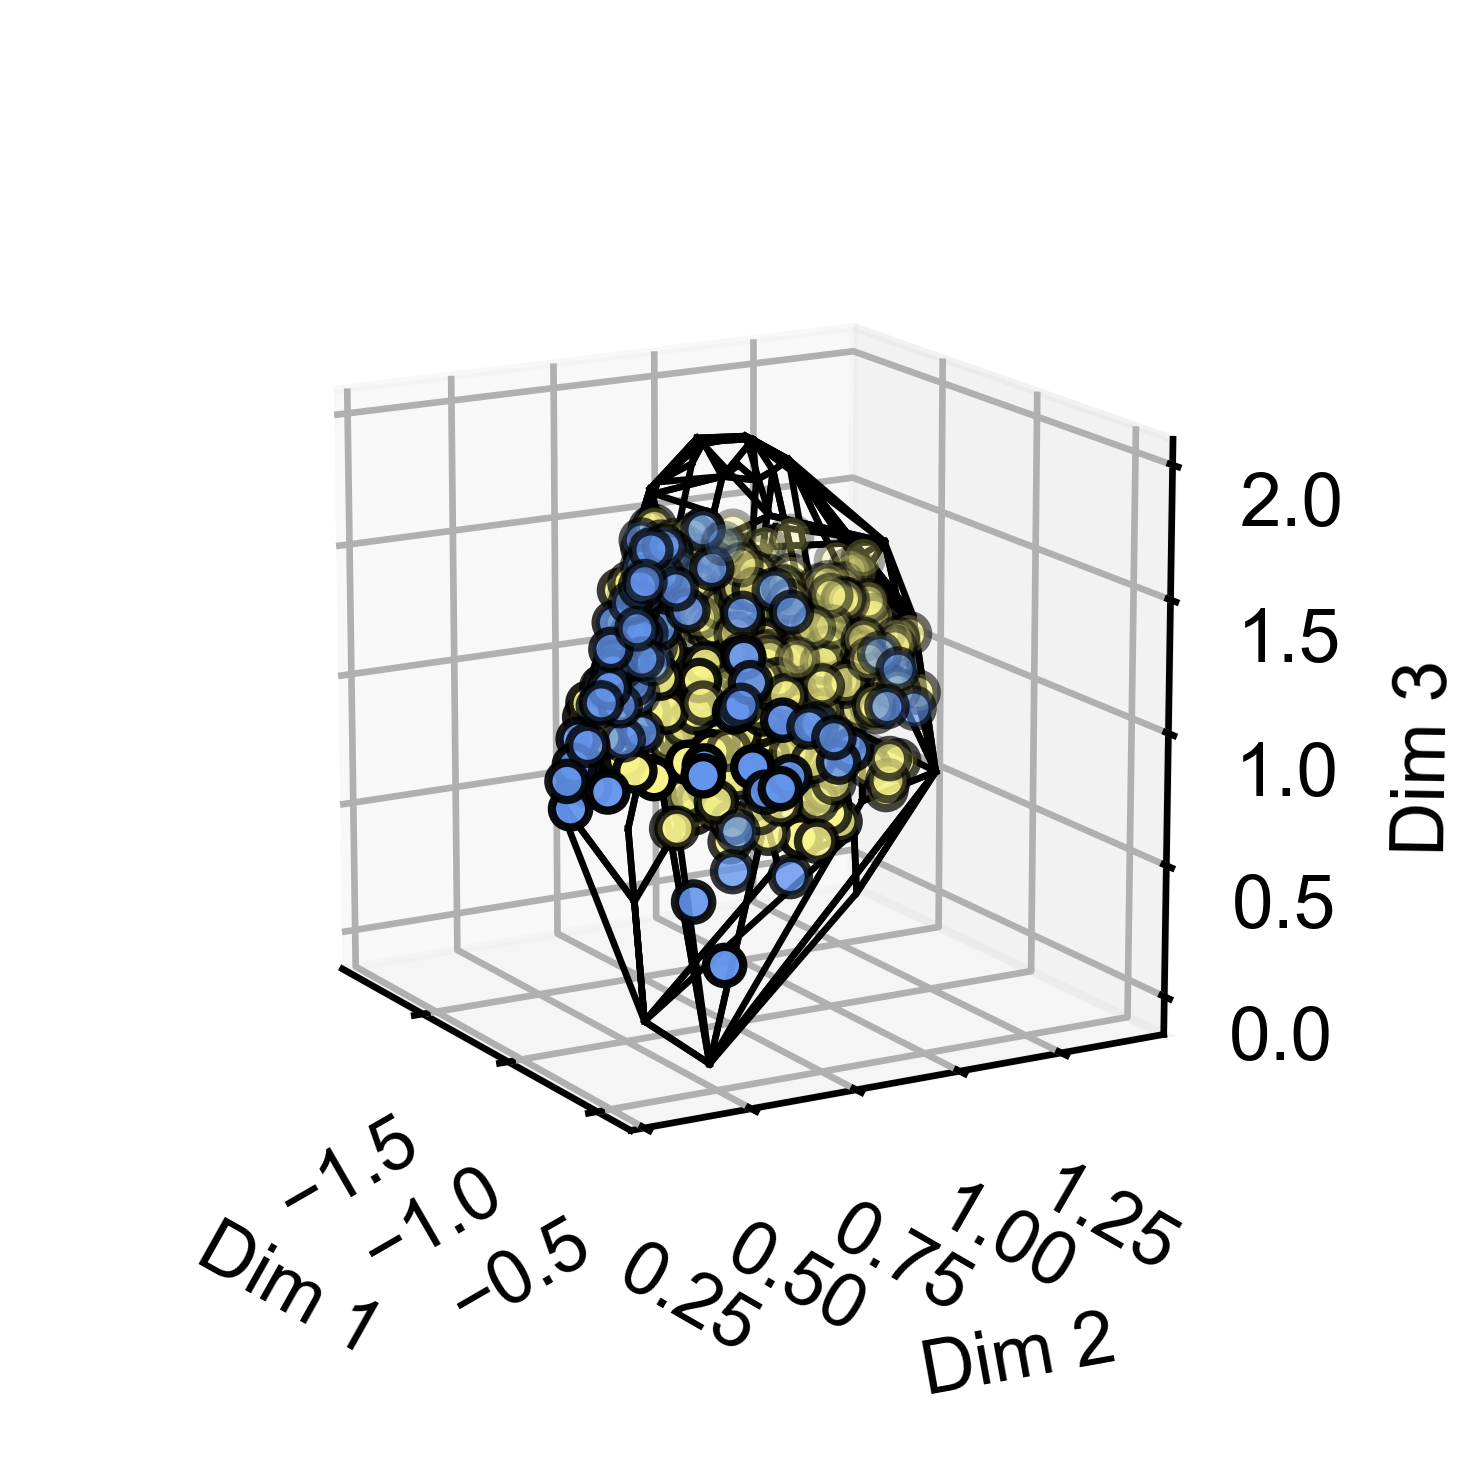

In [11]:
for fig_idx, rot_val in zip([0], [-30]):
    fig = plt.figure(figsize = (2.5,2.5),dpi = 600)

    ax = plt.axes(projection="3d")
    ax.view_init(15, rot_val)
    
    ax.scatter(good_des_mmd_coor[fdp,0], good_des_mmd_coor[fdp,1], good_des_mmd_coor[fdp,2], c='#F7F48B',
    edgecolor = 'k', s = 20)
    ax.scatter(nogood_des_mmd_coor[ufdp,0], nogood_des_mmd_coor[ufdp,1], 
               nogood_des_mmd_coor[ufdp,2], c='cornflowerblue', edgecolor = 'k', s = 20)

    for simplex in ortho_hull.simplices:
        ax.plot(ortho_mmd[simplex, 0], ortho_mmd[simplex, 1],  ortho_mmd[simplex, 2], 'k-',lw=.8)

    ax.set_xlabel('Dim 1', labelpad=9)
    ax.set_ylabel('Dim 2', labelpad=9)
    ax.set_zlabel('Dim 3')
    ax.dist = 12.4
    plt.yticks(rotation=-30)
    plt.xticks([-1.5,-1,-.5],rotation=30)
plt.tight_layout()
#plt.savefig('../../VAE_design_paper/Figs_202207/inhull_alldes.svg')

In [12]:
good_des_mmd_local_coor = design_mmd[np.intersect1d(mmd_local,good_des_mmd)]
nogood_des_mmd_local_coor = design_mmd[np.intersect1d(mmd_local,no_good_des_mmd)]

good_des_mmd_local_coor_plot = good_des_mmd_local_coor
fdp_o = check_hull_list(good_des_mmd_local_coor_plot,ortho_hull) 

nogood_des_mmd_local_coor_plot = nogood_des_mmd_local_coor
ufdp_o = check_hull_list(nogood_des_mmd_local_coor_plot,ortho_hull) 

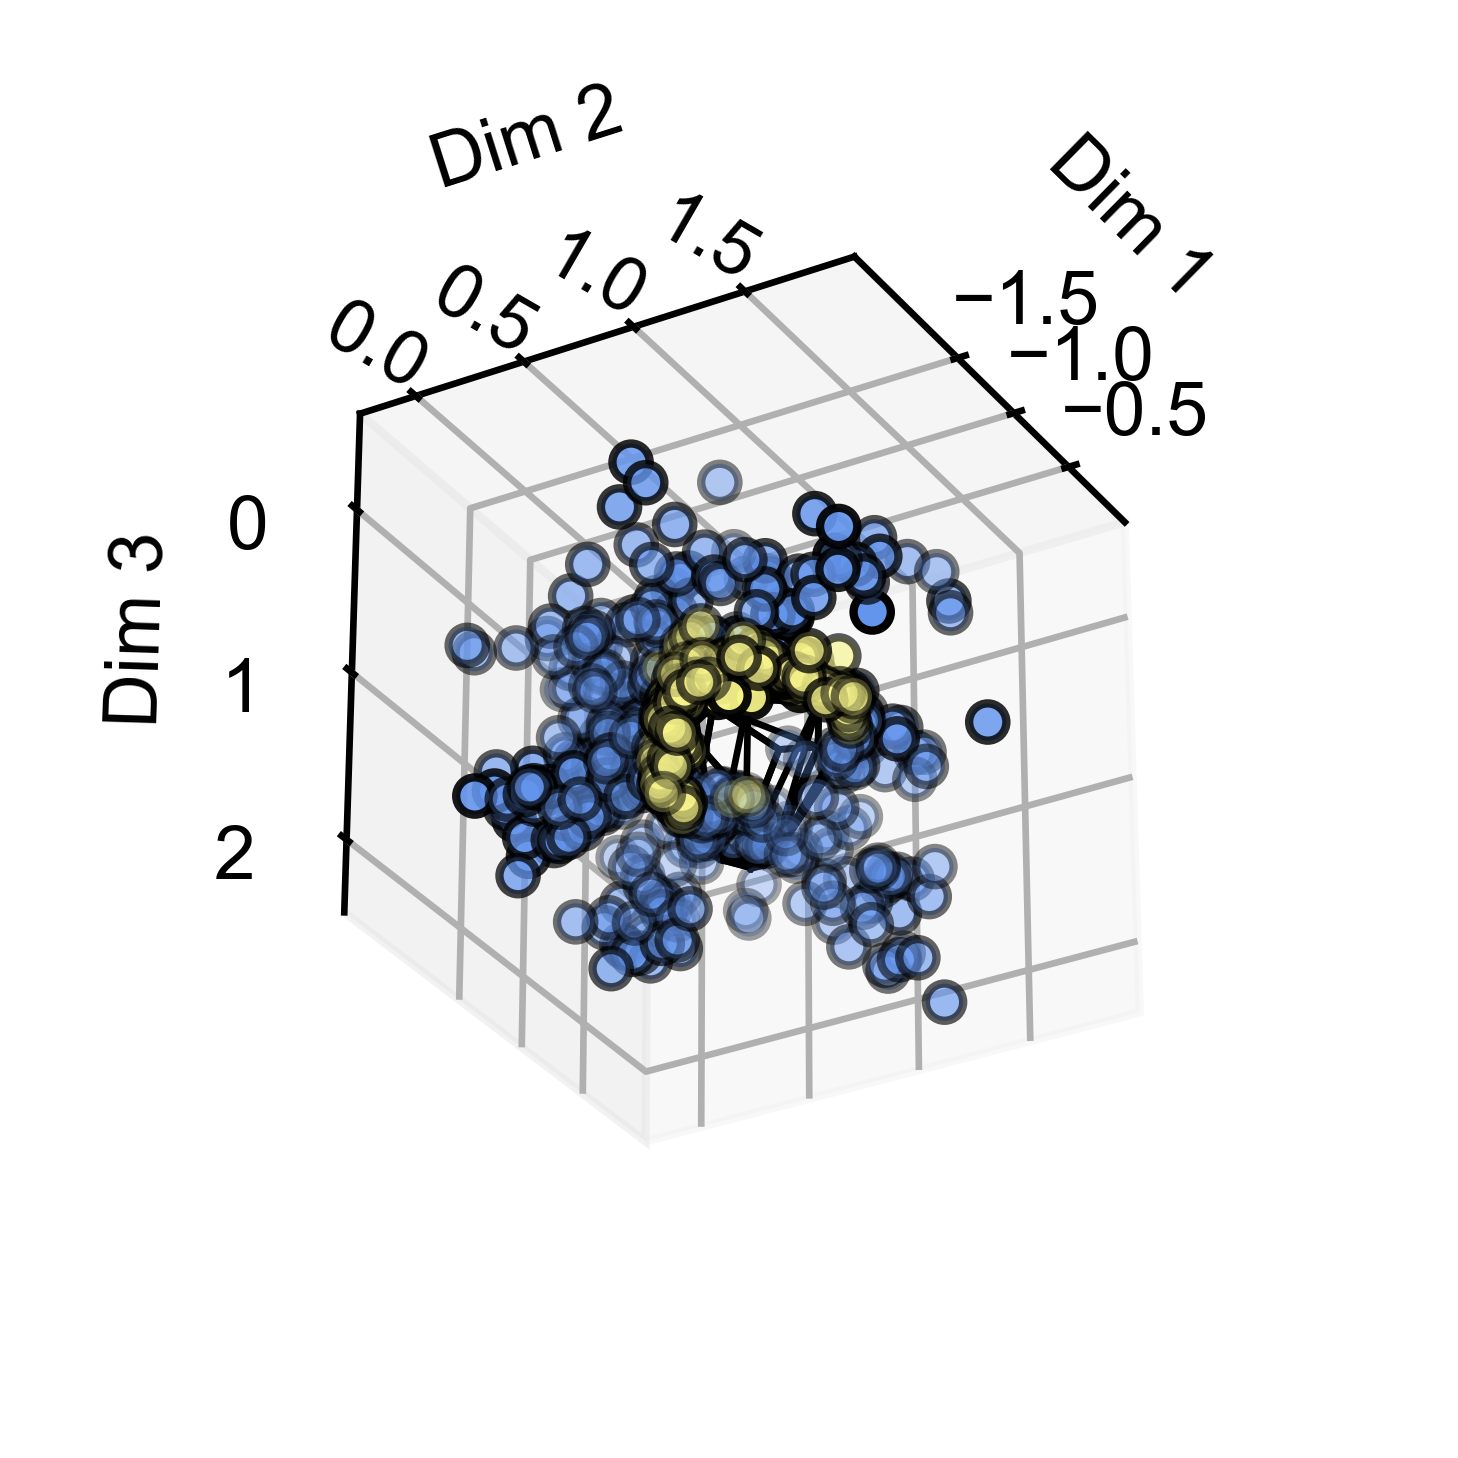

In [13]:
for fig_idx, rot_val in zip([0], [-30]):
    fig = plt.figure(figsize = (2.5,2.5),dpi = 600)

    ax = plt.axes(projection="3d")
    ax.view_init(150, rot_val)
    
    ax.scatter(good_des_mmd_local_coor_plot[~fdp_o,0], good_des_mmd_local_coor_plot[~fdp_o,1], 
               good_des_mmd_local_coor_plot[~fdp_o,2], c='#F7F48B',
        label='Training $\mathcal{L}$', edgecolor = 'k', s = 20)
    ax.scatter(nogood_des_mmd_local_coor_plot[~ufdp_o,0], nogood_des_mmd_local_coor_plot[~ufdp_o,1], 
               nogood_des_mmd_local_coor_plot[~ufdp_o,2], c='cornflowerblue',
        label='Training $\mathcal{L}$', edgecolor = 'k', s = 20)

    for simplex in ortho_hull.simplices:
        ax.plot(ortho_mmd[simplex, 0], ortho_mmd[simplex, 1],  ortho_mmd[simplex, 2], 'k-',lw=.8)

    ax.set_xlabel('Dim 1', labelpad=2)
    ax.set_ylabel('Dim 2', labelpad=.5)
    ax.set_zlabel('Dim 3', labelpad=1)
    ax.dist = 13.2
    #ax.tick_params(axis='x', which='major', pad=15)
    plt.yticks(rotation=-30)
    plt.xticks([-1.5,-1,-.5],rotation=0)
plt.tight_layout()
plt.show()

In [14]:
N_nat = len(nogood_nat_mmd_coor[nofunc_class_nat==1])+len(good_nat_mmd_coor[func_class_nat==1])
Nf_nat = len(good_nat_mmd_coor[func_class_nat==1])
r_nat = round(100*Nf_nat/N_nat,1)

N_in = len(good_des_mmd_coor[fdp]) + len(nogood_des_mmd_coor[ufdp])
Nf_in = len(good_des_mmd_coor[fdp])
r_in = round(100*Nf_in/N_in,1)

N_out = len(good_des_mmd_local_coor_plot[~fdp_o]) + len(nogood_des_mmd_local_coor_plot[~ufdp_o])
Nf_out = len(good_des_mmd_local_coor_plot[~fdp_o])
r_out = round(100*Nf_out/N_out,1)

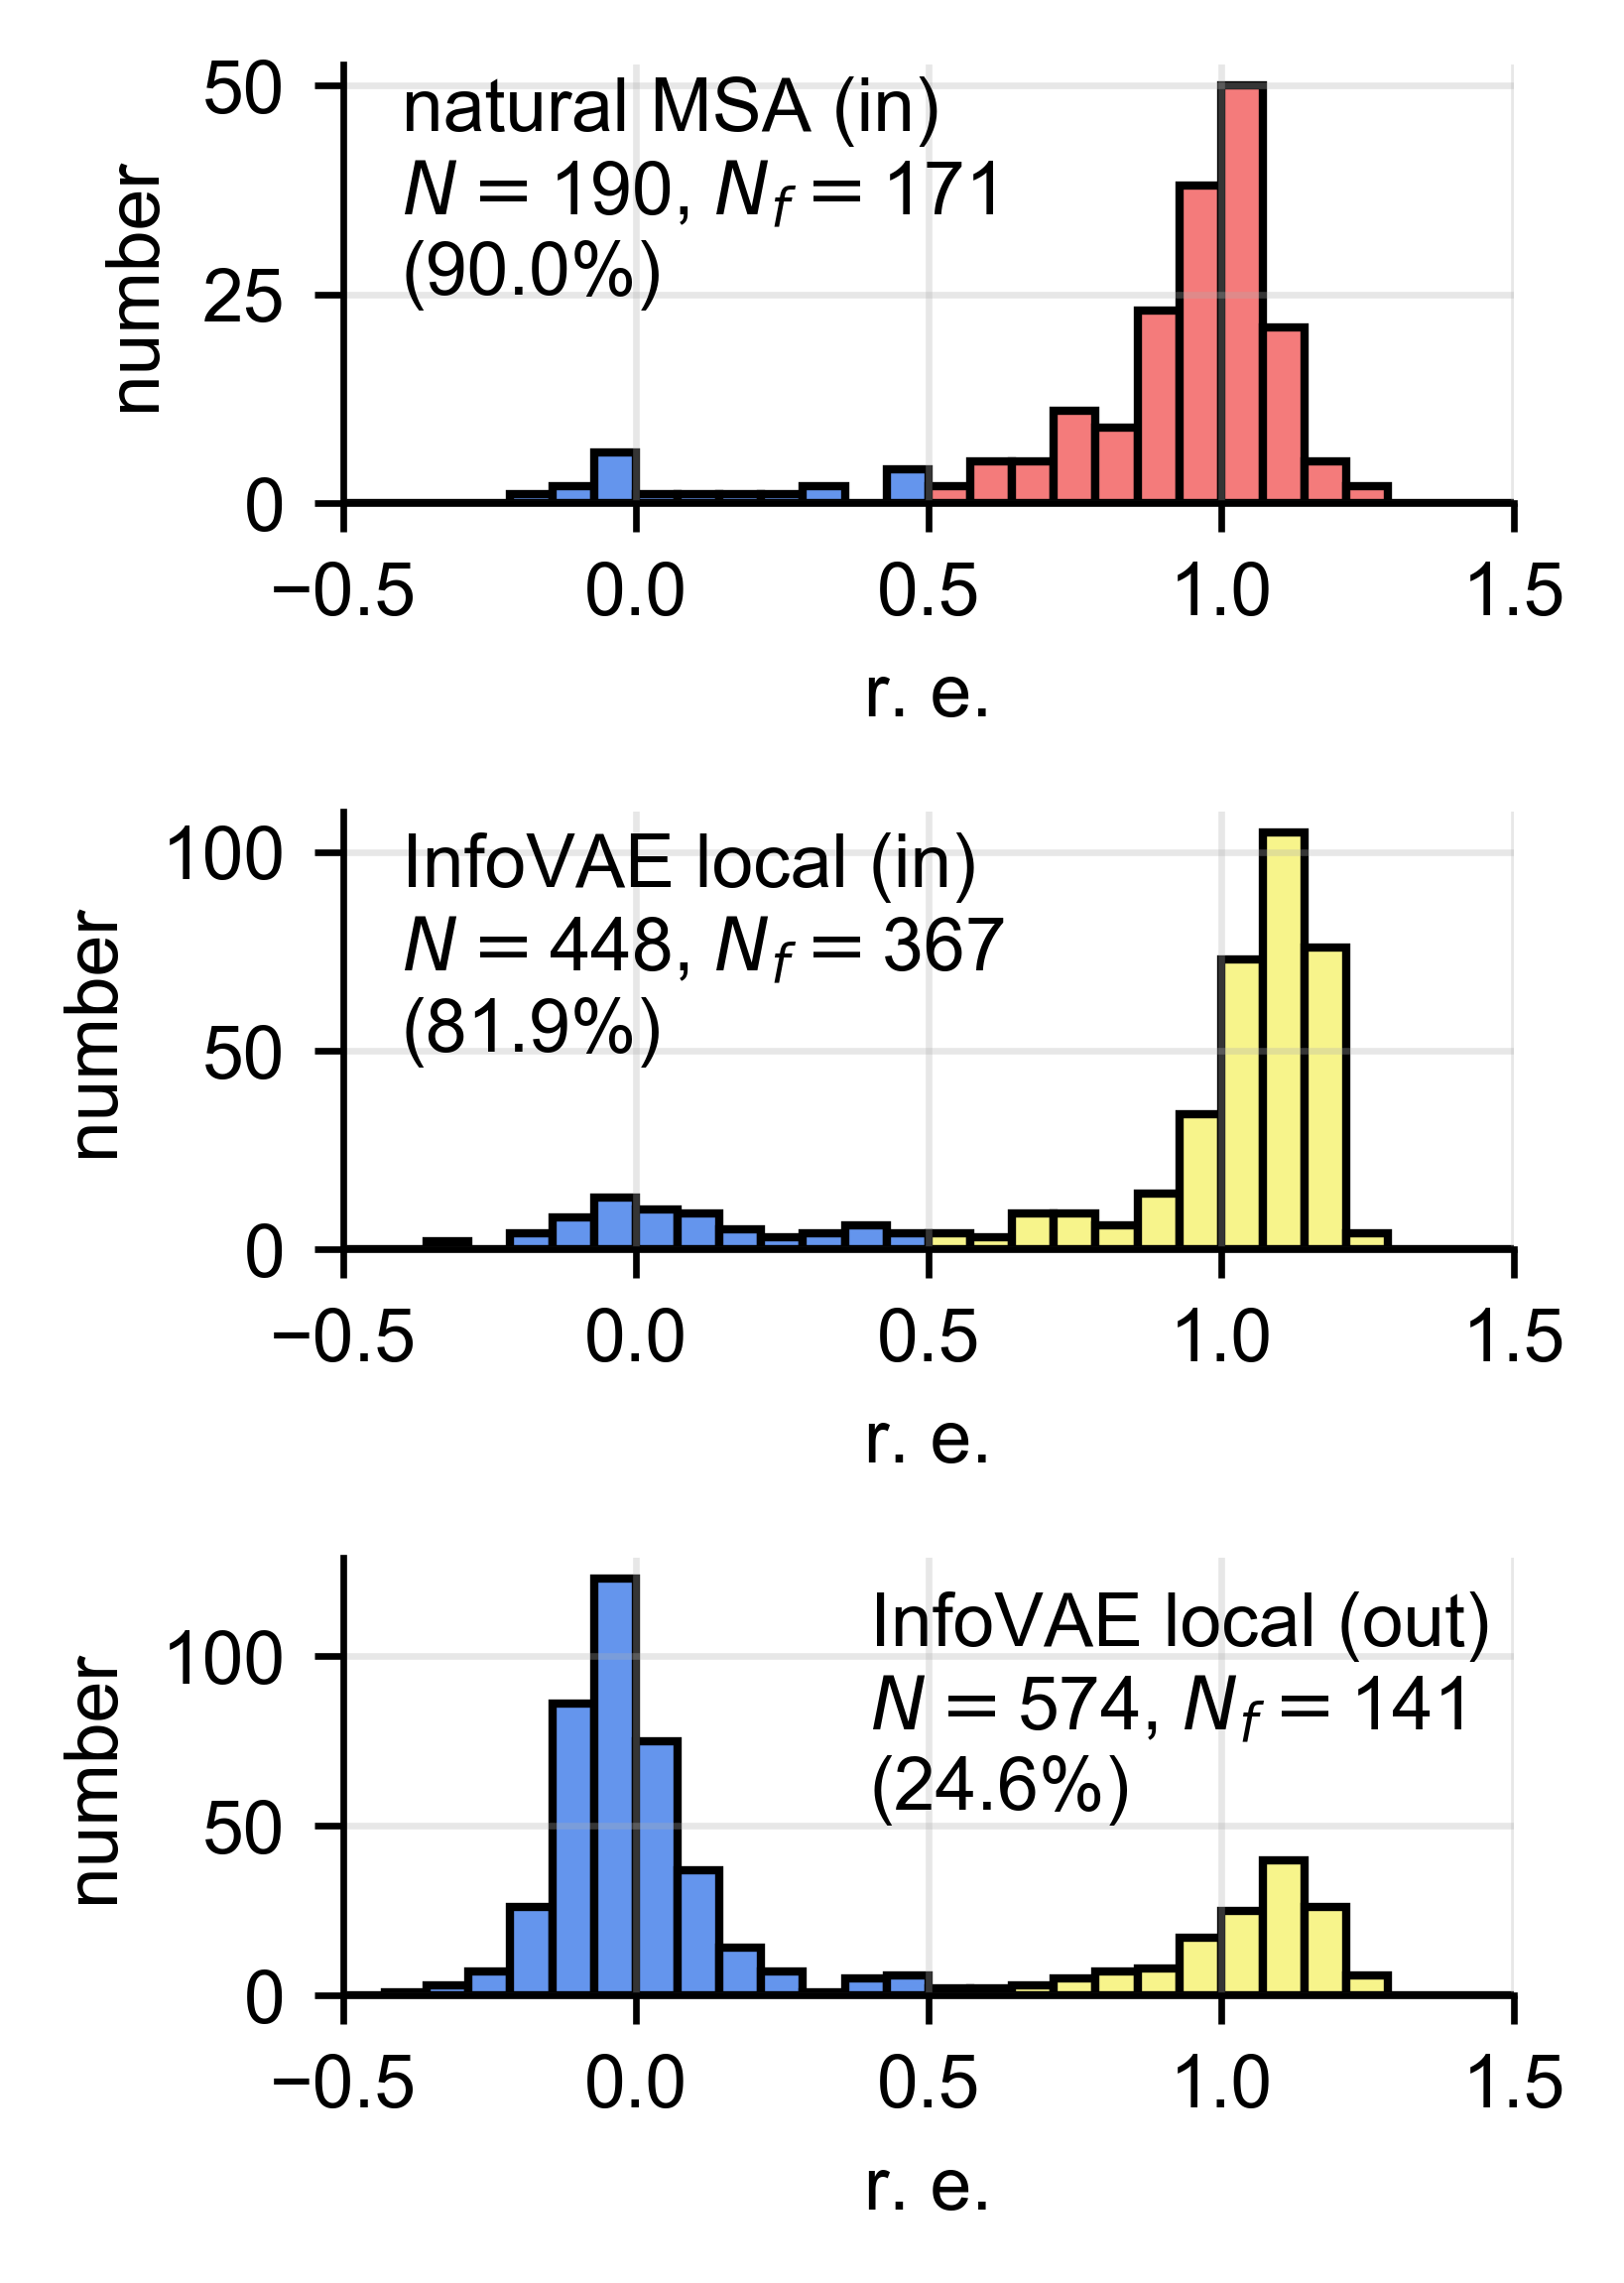

In [15]:
fig,axs=plt.subplots(3,1,figsize=[2.8,3.9],dpi=600)
patches=[0,0,0]
N_hist1, bins, patches[0]=axs[0].hist(RE_nat[class_nat],np.linspace(-.5,1.5,29),color='#f47b7b',edgecolor='k')
N_hist1, bins, patches[1]=axs[1].hist(res[mmd_local][class_des_mmd],np.linspace(-.5,1.5,29),color='#F7F48B',edgecolor='k')
N_hist1, bins, patches[2]=axs[2].hist(res[mmd_local][~class_des_mmd],np.linspace(-.5,1.5,29),color='#F7F48B',edgecolor='k')
#plt.setp(axs[0].get_xticklabels(), visible=False)
#plt.setp(axs[1].get_xticklabels(), visible=False)
axs[0].set_yticks([0,25,50])
axs[1].set_yticks([0,50,100])
axs[2].set_yticks([0,50,100])
axs[0].text(-.4,25, 'natural MSA (in)\n$N = $' + str(N_nat) + ', $N_f =$'+str(Nf_nat)+'\n('+str(r_nat)+'%)')
axs[1].text(-.4,50, 'InfoVAE local (in)\n$N = $' + str(N_in) + ', $N_f =$'+str(Nf_in)+'\n('+str(r_in)+'%)')
axs[2].text(.4,55, 'InfoVAE local (out)\n$N = $' + str(N_out) + ', $N_f =$'+str(Nf_out)+'\n('+str(r_out)+'%)')
for i in range(3):
    axs[i].set_xlabel('r. e.')
    axs[i].set_ylabel('number')
    axs[i].set_xlim(-.5,1.5)
    axs[i].grid(alpha=.3)
    axs[i].spines['right'].set_visible(False)
    axs[i].spines['top'].set_visible(False)
    for j in range(0,14):    
        patches[i][j].set_facecolor('cornflowerblue')
plt.tight_layout()
#plt.savefig('/Users/xinran/Documents/VAE_design_paper/Fig4/hull_RE2.pdf')
plt.show()

## Volume-ratio

In [19]:
vertices = ortho_mmd[ortho_hull.vertices]
centroid = np.array([-1.1180,0.8458,1.0742])

class convex_hulls:
    def __init__(self, ratio):
        self.vertices = centroid + (vertices - centroid) * ratio
        self.hull = ConvexHull(self.vertices)
    def check(self,coor):
        return check_hull_list(coor, self.hull)

In [20]:
good_all = np.vstack([good_nat_mmd_coor,good_des_mmd_coor])
nogood_all = np.vstack([nogood_nat_mmd_coor,nogood_des_mmd_coor])

In [21]:
hull1 = convex_hulls(1/3)
hull2 = convex_hulls(2/3)
hull3 = convex_hulls(1)
hull4 = convex_hulls(4/3)
hull5 = convex_hulls(5/3)
hull6 = convex_hulls(2)
hull_list = [hull1,hull2,hull3,hull4,hull5,hull6]

In [22]:
good_n = []
nogood_n = []
for i in hull_list:
    good_n.append(np.count_nonzero(i.check(good_all)))
    nogood_n.append(np.count_nonzero(i.check(nogood_all)))

good_shell = [good_n[0]] + [good_n[i]-good_n[i-1] for i in range(1,len(good_n))]
nogood_shell = [nogood_n[0]] + [nogood_n[i]-nogood_n[i-1] for i in range(1,len(nogood_n))]

good_shell = np.array(good_shell)
nogood_shell = np.array(nogood_shell)

ratio = good_shell/(good_shell+nogood_shell)
ratio = np.round(ratio,2)

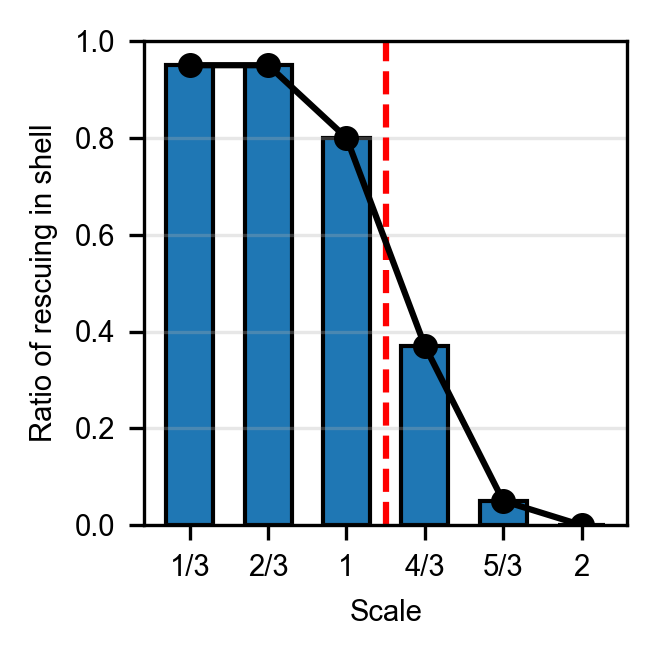

In [28]:
ratio_plot = ['1/3', '2/3', '1', '4/3', '5/3','2']

plt.figure(figsize = [2.2,2.2],dpi=300)
plt.grid(alpha=.3,axis='y')
plt.plot([2.5,2.5],[0,1],'r--')
plt.bar(ratio_plot, ratio,edgecolor='k', width=.6)
plt.plot(ratio_plot, ratio,'ko-', ms=5)
plt.xlabel('Scale')
plt.ylabel('Ratio of rescuing in shell')
plt.ylim([0,1])
plt.tight_layout()
#plt.savefig('../../VAE_design_paper/Figs_202207/ratio_hull.svg')
plt.show()

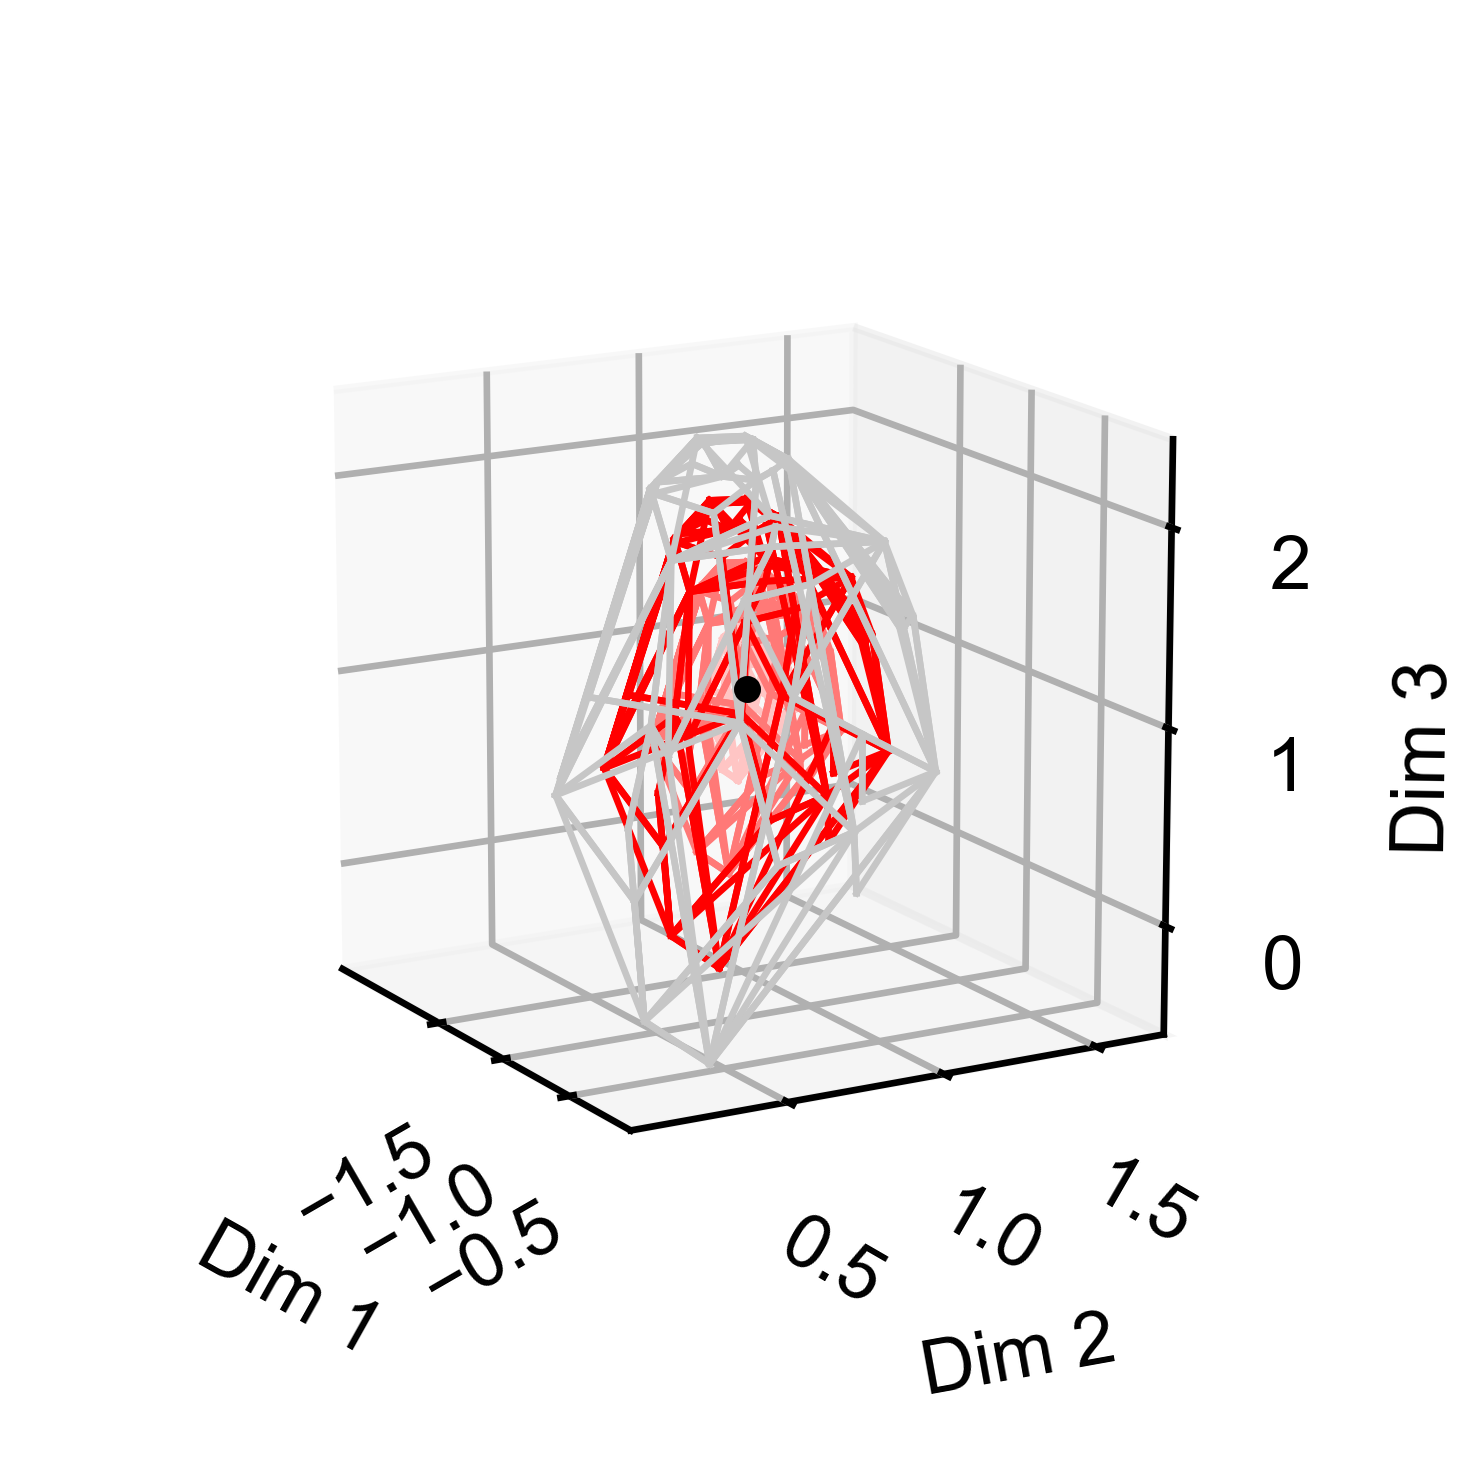

In [34]:
clist = ['#FFC5C4','#FF7977','red','#C6C6C6','silver','gainsboro']
for fig_idx, rot_val in zip([0], [-30]):
    fig = plt.figure(figsize = (2.5,2.5),dpi = 600)

    ax = plt.axes(projection="3d")
    ax.view_init(15, rot_val)
    ax.scatter(-1.1180,0.8458,1.0742,s=5, c = 'k')
    
    #p = ax.scatter(des_mmd_coor[:,0], des_mmd_coor[:,1], des_mmd_coor[:,2], s = 5)
    
    for num, h in enumerate(hull_list[:4]):
        for simplex in h.hull.simplices:
            ax.plot(h.vertices[simplex, 0], h.vertices[simplex, 1],  h.vertices[simplex, 2],
                    c = clist[num],lw=.8)

    #for simplex in ortho_hull.simplices:
    #    ax.plot(ortho_mmd[simplex, 0], ortho_mmd[simplex, 1],  ortho_mmd[simplex, 2], 'k-',lw=.8)

    ax.set_xlabel('Dim 1', labelpad=9)
    ax.set_ylabel('Dim 2', labelpad=9)
    ax.set_zlabel('Dim 3')
    ax.dist = 12.4
    plt.yticks(rotation=-30)
    plt.xticks([-1.5,-1,-.5],rotation=30)
plt.tight_layout()
plt.savefig('/Users/xinran/Documents/VAE_design_paper/Fig4/hull_shell.pdf')

## Entropy

In [16]:
mmd_seq=[designed_seq[i] for i in mmd_all]
des_mmd_coor_all = design_mmd[mmd_all] 

class_nat = check_hull_list(mmd_nat_coord,ortho_hull)
class_des_mmd_all = check_hull_list(des_mmd_coor_all,ortho_hull)

inhull_seq=[SH3[i] for i in range(len(class_nat)) if class_nat[i]==1]+\
           [mmd_seq[i] for i in range(len(class_des_mmd_all)) if class_des_mmd_all[i]==1]

func_seq=[SH3[i] for i in good_nat] + [designed_seq[i] for i in good_des_mmd]

all_seq=SH3.tolist()+mmd_seq

In [17]:
entropy_inhull = compute_entropy(inhull_seq)
entropy_func = compute_entropy(func_seq)
entropy_all = compute_entropy(all_seq)

entropy_diff = entropy_all-entropy_inhull
ediff_func = entropy_all-entropy_func

In [18]:
pos_list=np.array([2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 
       20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
       35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 47, 48, 49, 50, 51,
       52, 53, 54, 55, 56, 57, 58, 59, 60, 61,62,63])

In [19]:
sho1='NFIYKAKALYPYDADDAYEISFEQNEILQVSDIEGRWWKARRNGETGIIPSNYVQLIDG'

top_n = 9
top_color_list = []
print('Top %d entropy decreasing positions (all - inhull):\n' %top_n)
for i in entropy_diff.argsort()[-top_n:]:
    print(sho1[i]+str(pos_list[i]), end = ' ')
    top_color_list.append(i)
    
print('\n')
print('Top %d entropy decreasing positions (all - func):\n' %top_n)
for i in ediff_func.argsort()[-top_n:]:
    print(sho1[i]+str(pos_list[i]), end = ' ')

Top 9 entropy decreasing positions (all - inhull):

D62 S24 K42 I52 Y5 D35 G63 G38 S55 

Top 9 entropy decreasing positions (all - func):

S24 D62 K42 I52 Y5 G38 S55 G63 D35 

In [20]:
def R2(x_values,y_values):
    correlation_matrix = np.corrcoef(x_values, y_values)
    correlation_xy = correlation_matrix[0,1]
    return correlation_xy**2

print(R2(entropy_diff,ediff_func))

0.9696402537223133


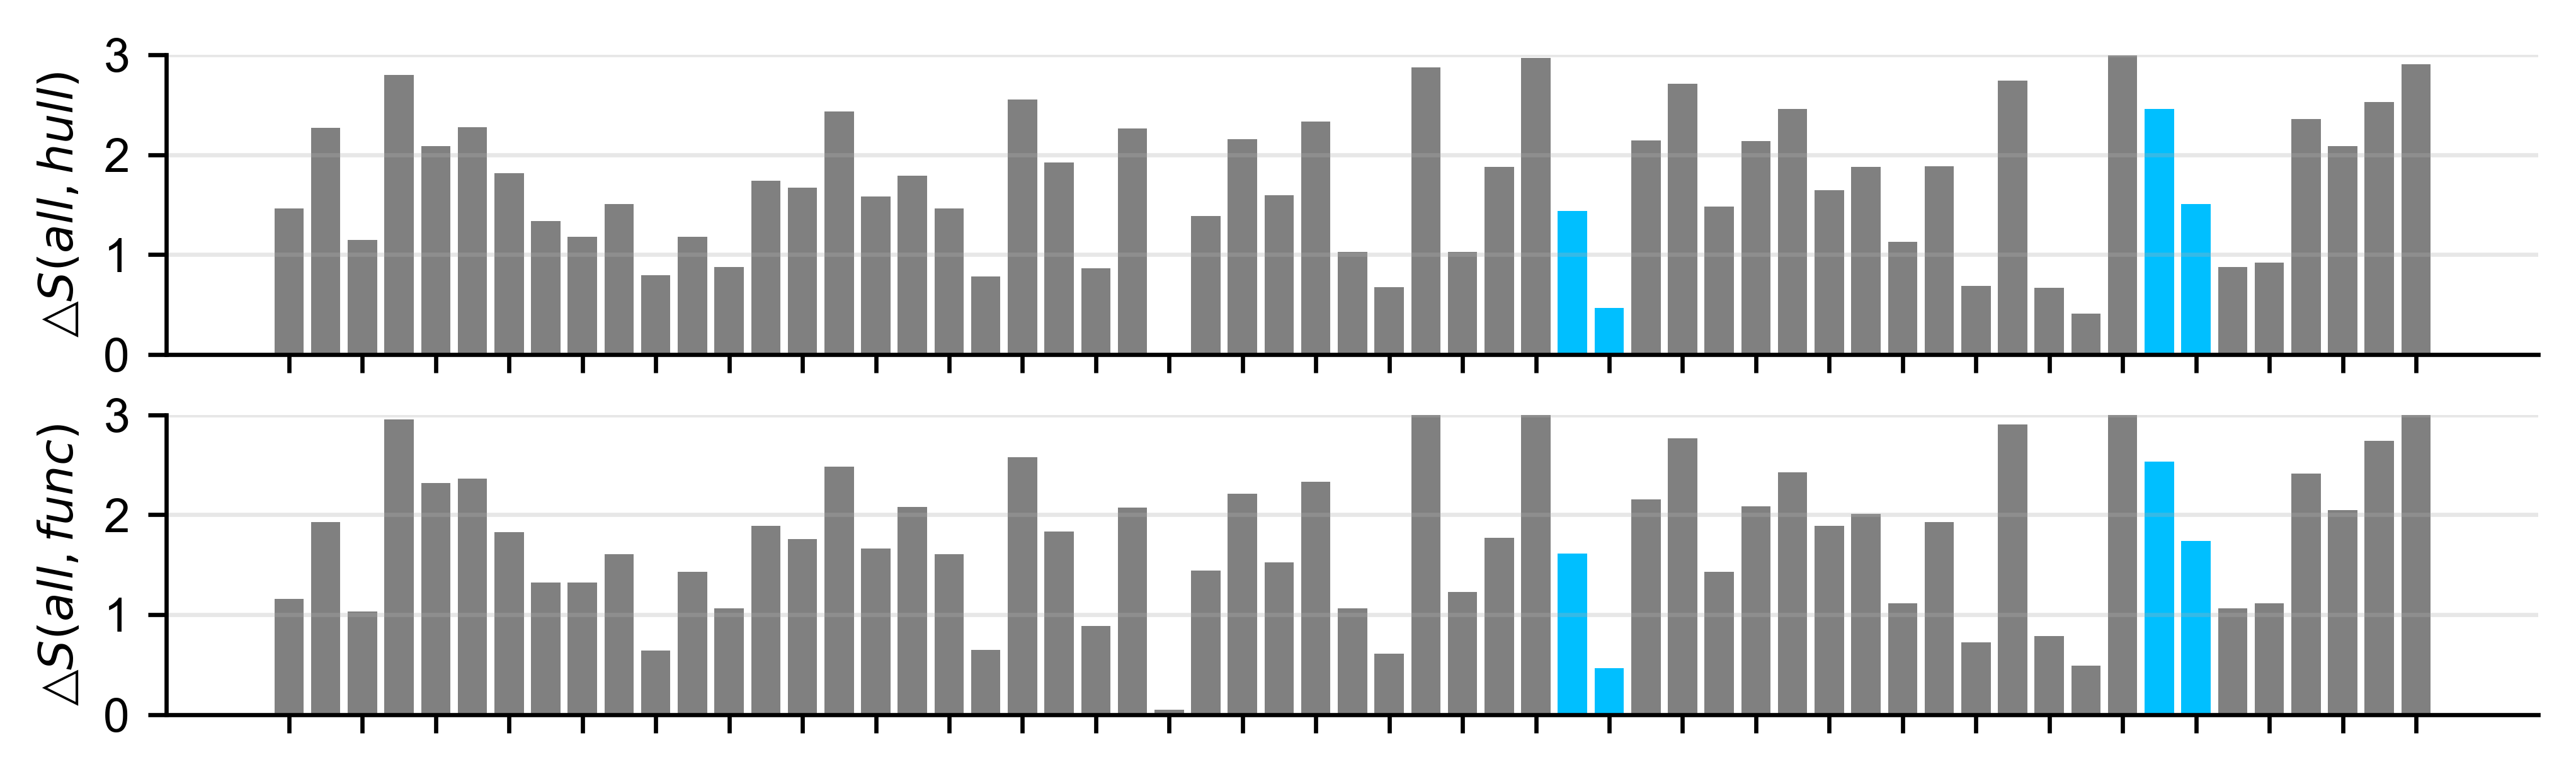

In [28]:
fig, ax = plt.subplots(2,1,figsize = [8.099,2.314],dpi=600)
bars = ax[0].bar(np.arange(59),entropy_diff,color='gray')
bars2 = ax[1].bar(np.arange(59),ediff_func,color='gray')
'''
for i in top_color_list:
    if i <55:
        bars[i].set_facecolor('orange')
        bars2[i].set_facecolor('orange')
'''
for i in [35,36,51,52]:
    bars[i].set_facecolor('deepskyblue')
    bars2[i].set_facecolor('deepskyblue')
    
ax[0].set_ylabel('$△S(all, hull)$')
ax[1].set_ylabel('$△S(all, func)$')

for i in range(2):
    ax[i].set_xticks(np.arange(0,59,2))
    ax[i].spines['right'].set_visible(False)
    ax[i].spines['top'].set_visible(False)
    ax[i].yaxis.grid(alpha=.3)
    ax[i].set_ylim([0,3])
    plt.setp(ax[i].get_xticklabels(), visible=False)
plt.savefig('../../VAE_design_paper/Figs_202207/S_hull.svg')
plt.show()

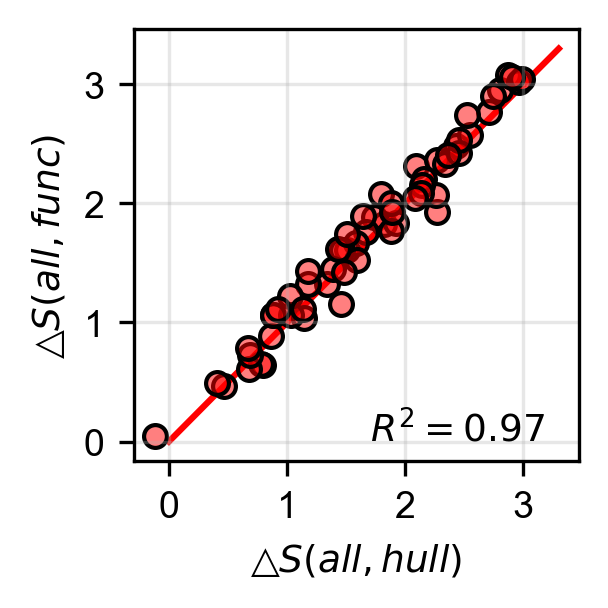

In [29]:
fig,ax = plt.subplots(1,1,figsize=[2.1,2.1],dpi=300)
ax.scatter(entropy_diff,ediff_func, edgecolor='k', facecolor=(1,.0,.0,.5), s = 30)
ax.plot([0,3.3],[0,3.3],'r',zorder=0)
plt.xlabel('$△S(all, hull)$')
plt.ylabel('$△S(all, func)$')
plt.grid(alpha=.3)
plt.text(1.7,.0,'$R^2 = 0.97$')
plt.yticks([0,1,2,3])
plt.xticks([0,1,2,3])
plt.tight_layout()
plt.savefig('../../VAE_design_paper/Fig4/E_diff.svg')
plt.show()